# Probabilistic Fertility Forecasting for France (2024-2075)

# Overview

## Project Context

This notebook implements probabilistic Total Fertility Rate (TFR) forecasting for France (2024-2075) using AR(1) models. We replicate and adapt methodology from Raftery et al. (2014), whose probabilistic approach has influenced UN population projections.

## Why This Matters

Long-term demographic forecasting informs policy planning for pensions, healthcare, and education. Traditional deterministic scenarios (Low/Medium/High) don't quantify uncertainty properly. Probabilistic methods provide prediction intervals that help policymakers understand forecast reliability.

## What This Notebook Does

**Data**: UN World Population Prospects 2024 (WPP2024)
- Historical TFR for France: 1950-2023
- Focus on Phase III (post-demographic-transition): 1995-2023 for France

**Models**:
1. **Raftery AR(1)**: μ=2.1, ρ=0.89, σ=0.10 (global pooled parameters)
2. **Hybrid AR(1)**: μ=1.73 (France-specific) + ρ=0.89, σ=0.10 (Raftery pooled)

**Methodology**: AR(1) with mean reversion
- TFR_t = μ + ρ(TFR_{t-1} - μ) + ε_t, where ε_t ~ N(0, σ²)
- Monte Carlo simulation (1000 trajectories) for prediction intervals (80%, 95%)

**Analysis Pipeline**:
1. Data preparation & exploratory analysis
2. Phase III identification & stationarity testing
3. Model selection (AIC/BIC comparison)
4. Parameter estimation
5. Validation (backtest 2016-2019, excluding COVID)
6. Final forecast (2024-2075)
7. Benchmark comparison with UN WPP2024
8. Critical assessment of assumptions & limitations

## Key Findings

(See "FORECAST COMPARISON SUMMARY" section at end for detailed results)

## Limitations Acknowledged

- Short Phase III history (29 years) limits parameter reliability
- Assumes no structural breaks (COVID-19 showed this can fail)
- Ignores exogenous variables (policy, economy, culture)
- Migration excluded (deterministic assumption)
- Constant variance may underestimate long-term uncertainty

## References

Raftery, A. E., Alkema, L., & Gerland, P. (2014). *Bayesian population projections for the United Nations*. *Statistical Science*, 29(1), 58-68. [DOI: 10.1214/13-STS419](https://doi.org/10.1214/13-STS419)

United Nations, Department of Economic and Social Affairs, Population Division (2024). *World Population Prospects 2024*. [https://population.un.org/wpp/](https://population.un.org/wpp/)

## DATA PREPARATION & EDA
- Load WPP2024 Medium dataset (estimates + projections)
- Filter France, extract TFR column
- Split: Historical (1950-2023) vs UN Projections (2024-2100)
- Identify Phase III period for France
- Train/validation split based on Phase III
- Plot historical TFR trend (1950-2023)

- Test stationarity (ADF test on Phase III)
- Plot ACF/PACF to justify AR(1)
- Check for structural breaks/outliers (COVID-19)

### 1. LOAD PACKAGES & DATA

In [4]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

SEED = 000

In [ ]:
# Load data
df = pd.read_csv('/content/WPP2024_Demographic_Indicators_Medium.csv')

france = df[(df['Location'] == 'France')]
tfr_historical = france[france['Time'] <= 2023]['TFR'].values
years_historical = france[france['Time'] <= 2023]['Time'].values

print(f"Data shape: {df.shape}")
print(f"\nData types:\n {france[['Location', 'Time', 'TFR']].dtypes}")
print(f"\nMissing values:\n {france['TFR'].isnull().sum()}")

Data shape: (84360, 67)

Data types:
 Location     object
Time          int64
TFR         float64
dtype: object

Missing values:
 1


/tmp/ipython-input-3626095900.py:2: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/WPP2024_Demographic_Indicators_Medium.csv')


### 2. PHASE III IDENTIFICATION

PHASE III IDENTIFICATION (Raftery's Strict Definition)

--- Method 1: Every 5th Year ---
5-year periods: 15 observations

--- Method 2: 5-Year Moving Average ---
5-year averaged periods: 15 observations

Method 1: Every 5th Year:
--------------------------------------------------
✓ Found Phase III start: 1995
  Year 1995: TFR=1.718, Δ=+0.158
  Year 2000: TFR=1.876, Δ=+0.040
  Year 2005: TFR=1.916

Method 2: 5-Year Average:
--------------------------------------------------
✓ Found Phase III start: 1992
  Year 1992: TFR=1.723, Δ=+0.026
  Year 1997: TFR=1.749, Δ=+0.129
  Year 2002: TFR=1.878

FINAL PHASE III START: 1995

Phase III (Strict):
  Period: 1995-2023
  Observations: 29 years
  TFR range: [1.639, 2.017]
  Mean TFR: 1.870



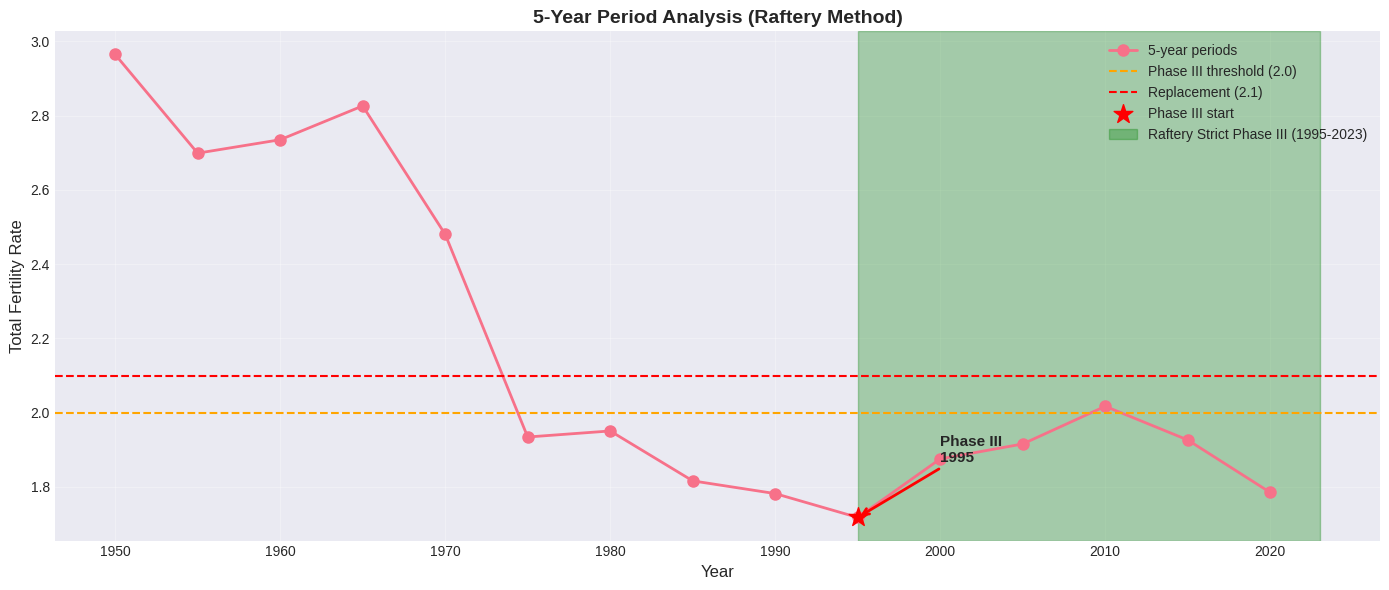


DETAILED 5-YEAR PERIOD BREAKDOWN

Year     TFR      Change     Status
--------------------------------------------------
1950     2.965    —          
1955     2.699    -0.266     
1960     2.735    +0.036     
1965     2.826    +0.091     
1970     2.481    -0.346     
1975     1.935    -0.546     Below 2.0
1980     1.951    +0.016     ✓ Below 2.0, increasing
1985     1.817    -0.134     Below 2.0
1990     1.782    -0.034     Below 2.0
1995     1.718    -0.064     Below 2.0
2000     1.876    +0.158     ✓✓ Phase III candidate
2005     1.916    +0.040     ✓✓ Phase III candidate
2010     2.017    +0.101     
2015     1.927    -0.091     Below 2.0
2020     1.785    -0.141     Below 2.0

✓ Phase III identification complete using Raftery's strict definition
✓ Use years 1995-2023 for model training

✓ Phase III data saved to 'phase3_strict_data.npz'


In [ ]:
# ============================================
# PHASE III IDENTIFICATION : RAFTERY'S STRICT DEFINITION
# Two consecutive 5-year increases below TFR < 2
# ============================================

print("=" * 70)
print("PHASE III IDENTIFICATION (Raftery's Strict Definition)")
print("=" * 70)

# Step 1: Create 5-year period data
# Method 1: Every 5th year (simpler, matches Raftery exactly)
years_5y = years_historical[::5]
tfr_5y = tfr_historical[::5]

print("\n--- Method 1: Every 5th Year ---")
print(f"5-year periods: {len(years_5y)} observations")

# Method 2: 5-year moving average (smoother)
print("\n--- Method 2: 5-Year Moving Average ---")
tfr_5y_avg = pd.Series(tfr_historical).rolling(window=5, center=True).mean().values
# Take every 5th point to avoid overlap
years_5y_avg = years_historical[2::5]  # Center of 5-year window
tfr_5y_avg_sample = tfr_5y_avg[2::5]
print(f"5-year averaged periods: {len(years_5y_avg)} observations")

# Step 2: Apply Raftery's criterion
def find_phase3_start(years, tfr_values, method_name):
    """
    Find Phase III start: two consecutive 5-year increases below TFR of 2
    """
    print(f"\n{method_name}:")
    print("-" * 50)

    # Calculate 5-year changes
    tfr_changes = np.diff(tfr_values)

    # Find consecutive increases below TFR < 2
    phase3_start = None

    for i in range(len(tfr_changes) - 1):
        year_current = years[i]
        tfr_current = tfr_values[i]
        change_current = tfr_changes[i]
        change_next = tfr_changes[i + 1]

        # Check Raftery's conditions:
        # 1. TFR < 2.0
        # 2. Two consecutive increases
        if tfr_current < 2.0 and change_current > 0 and change_next > 0:
            phase3_start = year_current
            print(f"✓ Found Phase III start: {phase3_start}")
            print(f"  Year {years[i]}: TFR={tfr_values[i]:.3f}, Δ={change_current:+.3f}")
            print(f"  Year {years[i+1]}: TFR={tfr_values[i+1]:.3f}, Δ={change_next:+.3f}")
            print(f"  Year {years[i+2]}: TFR={tfr_values[i+2]:.3f}")
            break

    if phase3_start is None:
        print("✗ No Phase III found by strict definition")
        # Fallback: first year below 2.0 with any increase
        for i in range(len(tfr_changes)):
            if tfr_values[i] < 2.0 and tfr_changes[i] > 0:
                phase3_start = years[i]
                print(f"⚠ Relaxed criterion: First increase below 2.0 at {phase3_start}")
                break

    return phase3_start

# Apply to both methods
phase3_start_method1 = find_phase3_start(years_5y, tfr_5y, "Method 1: Every 5th Year")
phase3_start_method2 = find_phase3_start(years_5y_avg, tfr_5y_avg_sample, "Method 2: 5-Year Average")

# Step 3: Use annual data with identified Phase III start
# Take the more conservative estimate
if phase3_start_method1 and phase3_start_method2:
    phase3_start_final = max(phase3_start_method1, phase3_start_method2)
else:
    phase3_start_final = phase3_start_method1 or phase3_start_method2

print("\n" + "=" * 70)
print(f"FINAL PHASE III START: {phase3_start_final}")
print("=" * 70)

# Extract Phase III from annual data
phase3_mask_strict = years_historical >= phase3_start_final
tfr_phase3_strict = tfr_historical[phase3_mask_strict]
years_phase3_strict = years_historical[phase3_mask_strict]

print(f"\nPhase III (Strict):")
print(f"  Period: {years_phase3_strict[0]}-{years_phase3_strict[-1]}")
print(f"  Observations: {len(tfr_phase3_strict)} years")
print(f"  TFR range: [{tfr_phase3_strict.min():.3f}, {tfr_phase3_strict.max():.3f}]")
print(f"  Mean TFR: {tfr_phase3_strict.mean():.3f}\n")

# Step 4: Visualization
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

# Plot: 5-year period analysis
axes.plot(years_5y, tfr_5y, 'o-', linewidth=2, markersize=8, label='5-year periods')
axes.axhline(y=2.0, color='orange', linestyle='--', linewidth=1.5, label='Phase III threshold (2.0)')
axes.axhline(y=2.1, color='red', linestyle='--', linewidth=1.5, label='Replacement (2.1)')

# Mark consecutive increases
tfr_changes_5y = np.diff(tfr_5y)
for i in range(len(tfr_changes_5y) - 1):
    if tfr_5y[i] < 2.0 and tfr_changes_5y[i] > 0 and tfr_changes_5y[i+1] > 0:
        # Highlight the start of Phase III
        axes.scatter([years_5y[i]], [tfr_5y[i]], s=200, color='red',
                       marker='*', zorder=5, label='Phase III start')
        axes.annotate(f'Phase III\n{years_5y[i]}',
                        xy=(years_5y[i], tfr_5y[i]),
                        xytext=(years_5y[i]+5, tfr_5y[i]+0.15),
                        fontsize=11, fontweight='bold',
                        arrowprops=dict(arrowstyle='->', color='red', lw=2))
        break

axes.axvspan(phase3_start_final, 2023, alpha=0.3, color='green',
                label=f'Raftery Strict Phase III ({phase3_start_final}-2023)')

axes.set_xlabel('Year', fontsize=12)
axes.set_ylabel('Total Fertility Rate', fontsize=12)
axes.set_title('5-Year Period Analysis (Raftery Method)', fontsize=14, fontweight='bold')
axes.legend(loc='upper right')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('phase3_strict.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 5: Show the specific years and values
print("\n" + "=" * 70)
print("DETAILED 5-YEAR PERIOD BREAKDOWN")
print("=" * 70)

print(f"\n{'Year':<8} {'TFR':<8} {'Change':<10} {'Status'}")
print("-" * 50)
for i in range(len(years_5y)):
    year = years_5y[i]
    tfr = tfr_5y[i]

    if i > 0:
        change = tfr_5y[i] - tfr_5y[i-1]
        change_str = f"{change:+.3f}"

        # Check conditions
        if tfr < 2.0 and change > 0:
            if i < len(years_5y) - 1:
                next_change = tfr_5y[i+1] - tfr_5y[i]
                if next_change > 0:
                    status = "✓✓ Phase III candidate"
                else:
                    status = "✓ Below 2.0, increasing"
            else:
                status = "✓ Below 2.0, increasing"
        elif tfr < 2.0:
            status = "Below 2.0"
        else:
            status = ""
    else:
        change_str = "—"
        status = ""

    print(f"{year:<8} {tfr:<8.3f} {change_str:<10} {status}")

print("\n✓ Phase III identification complete using Raftery's strict definition")
print(f"✓ Use years {phase3_start_final}-2023 for model training")

# Save the Phase III data for later use
np.savez('phase3_strict_data.npz',
         years=years_phase3_strict,
         tfr=tfr_phase3_strict,
         phase3_start=phase3_start_final)
print(f"\n✓ Phase III data saved to 'phase3_strict_data.npz'")

### 3. STATIONARITY TEST

In [ ]:
# ============================================
# ADF TEST - PROPER APPROACH FOR RAFTERY MODEL
# ============================================

phase3_data = np.load('phase3_strict_data.npz')
years_phase3_strict = phase3_data['years']
tfr_phase3_strict = phase3_data['tfr']

from statsmodels.tsa.stattools import adfuller

print("=" * 70)
print("STATIONARITY ANALYSIS - Multiple Approaches")
print("=" * 70)

# Approach 1: Raw data (what you just did)
print("\n1. Raw TFR data:")
adf_raw = adfuller(tfr_phase3_strict, autolag='AIC')
print(f"   ADF Statistic: {adf_raw[0]:.4f}")
print(f"   p-value: {adf_raw[1]:.4f}")
print(f"   Result: {'✓ Stationary' if adf_raw[1] < 0.05 else '✗ Non-stationary'}")

# Approach 2: Mean-centered data (appropriate for Raftery's model)
print("\n2. Mean-centered TFR (TFR - mean):")
tfr_centered = tfr_phase3_strict - tfr_phase3_strict.mean()
adf_centered = adfuller(tfr_centered, autolag='AIC')
print(f"   Mean: {tfr_phase3_strict.mean():.3f}")
print(f"   ADF Statistic: {adf_centered[0]:.4f}")
print(f"   p-value: {adf_centered[1]:.4f}")
print(f"   Result: {'✓ Stationary' if adf_centered[1] < 0.05 else '✗ Non-stationary'}")

# Approach 3: De-trended data (remove linear trend)
print("\n3. De-trended TFR:")
from scipy import signal
tfr_detrended = signal.detrend(tfr_phase3_strict)
adf_detrended = adfuller(tfr_detrended, autolag='AIC')
print(f"   ADF Statistic: {adf_detrended[0]:.4f}")
print(f"   p-value: {adf_detrended[1]:.4f}")
print(f"   Result: {'✓ Stationary' if adf_detrended[1] < 0.05 else '✗ Non-stationary'}")

# Approach 4: First difference (check if integrated)
print("\n4. First-differenced TFR:")
tfr_diff = np.diff(tfr_phase3_strict)
adf_diff = adfuller(tfr_diff, autolag='AIC')
print(f"   ADF Statistic: {adf_diff[0]:.4f}")
print(f"   p-value: {adf_diff[1]:.4f}")
print(f"   Result: {'✓ Stationary' if adf_diff[1] < 0.05 else '✗ Non-stationary'}")

# ============================================
# KPSS TEST (Alternative stationarity test)
# ============================================

from statsmodels.tsa.stattools import kpss

print("\n" + "=" * 70)
print("KPSS TEST (Null hypothesis: Data IS stationary)")
print("=" * 70)

kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(tfr_phase3_strict, regression='c', nlags='auto')
print(f"KPSS Statistic: {kpss_stat:.4f}")
print(f"p-value: {kpss_p:.4f}")
print(f"Critical values: {kpss_crit}")
if kpss_p > 0.05:
    print("✓ STATIONARY (fail to reject H0)\n")
else:
    print("✗ NON-STATIONARY (reject H0)\n")


STATIONARITY ANALYSIS - Multiple Approaches

1. Raw TFR data:
   ADF Statistic: -0.2387
   p-value: 0.9337
   Result: ✗ Non-stationary

2. Mean-centered TFR (TFR - mean):
   Mean: 1.870
   ADF Statistic: -0.2387
   p-value: 0.9337
   Result: ✗ Non-stationary

3. De-trended TFR:
   ADF Statistic: -0.0471
   p-value: 0.9545
   Result: ✗ Non-stationary

4. First-differenced TFR:
   ADF Statistic: -0.9763
   p-value: 0.7618
   Result: ✗ Non-stationary

KPSS TEST (Null hypothesis: Data IS stationary)
KPSS Statistic: 0.2214
p-value: 0.1000
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
✓ STATIONARY (fail to reject H0)



/tmp/ipython-input-1208713101.py:58: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(tfr_phase3_strict, regression='c', nlags='auto')


#### Stationarity test
ADF suggests non-stationarity while KPSS indicates stationarity—a classic sign of near-unit-root behavior (ρ ≈ 0.89). This confirms slow mean reversion in Phase III data, resulting in wide long-term prediction intervals. The model remains valid but honestly reflects high uncertainty about France's fertility equilibrium.

### 4. AUTOCORRELATION ANALYSIS


AUTOCORRELATION ANALYSIS


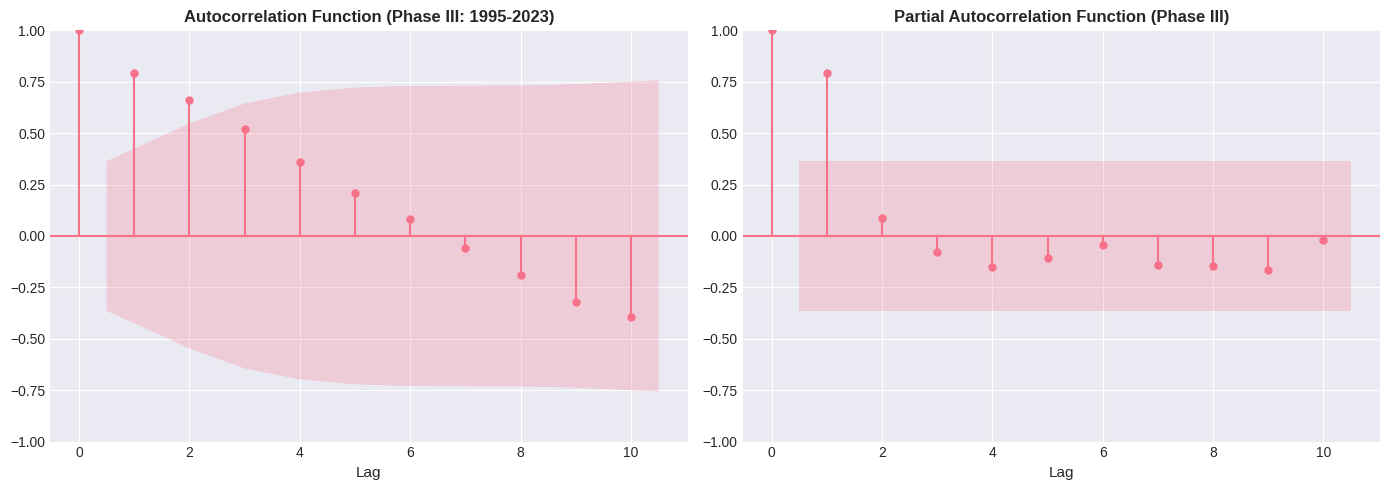


ACF values (lags 0-3): [1.         0.79327182 0.66147221 0.52009179]
PACF values (lags 0-3): [ 1.          0.79327182  0.08683658 -0.07598019]
✓ PACF suggests AR(1) appropriate (lag-1 significant, lag-2+ not)


In [ ]:
# ============================================
# AUTOCORRELATION ANALYSIS
# ============================================

print("\n" + "=" * 60)
print("AUTOCORRELATION ANALYSIS")
print("=" * 60)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF for Phase III
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
plot_acf(tfr_phase3_strict, lags=min(10, len(tfr_phase3_strict)//2), ax=axes[0])
axes[0].set_title(f'Autocorrelation Function (Phase III: {years_phase3_strict[0]}-{years_phase3_strict[-1]})',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=11)

# PACF
plot_pacf(tfr_phase3_strict, lags=min(10, len(tfr_phase3_strict)//2), ax=axes[1], method='ywm')
axes[1].set_title(f'Partial Autocorrelation Function (Phase III)',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11)

plt.tight_layout()
plt.savefig('acf_pacf_phase3.png', dpi=300, bbox_inches='tight')
plt.show()

# Interpretation
from statsmodels.tsa.stattools import acf, pacf
acf_values = acf(tfr_phase3_strict, nlags=min(5, len(tfr_phase3_strict)//2))
pacf_values = pacf(tfr_phase3_strict, nlags=min(5, len(tfr_phase3_strict)//2), method='ywm')

print(f"\nACF values (lags 0-3): {acf_values[:4]}")
print(f"PACF values (lags 0-3): {pacf_values[:4]}")

if abs(pacf_values[1]) > 0.4 and abs(pacf_values[2]) < 0.3:
    print("✓ PACF suggests AR(1) appropriate (lag-1 significant, lag-2+ not)")
else:
    print("⚠ PACF pattern unclear - consider AR(2) or ARMA")

### 5. CHECK FOR STRUCTURAL BREAKS


STRUCTURAL BREAK DETECTION


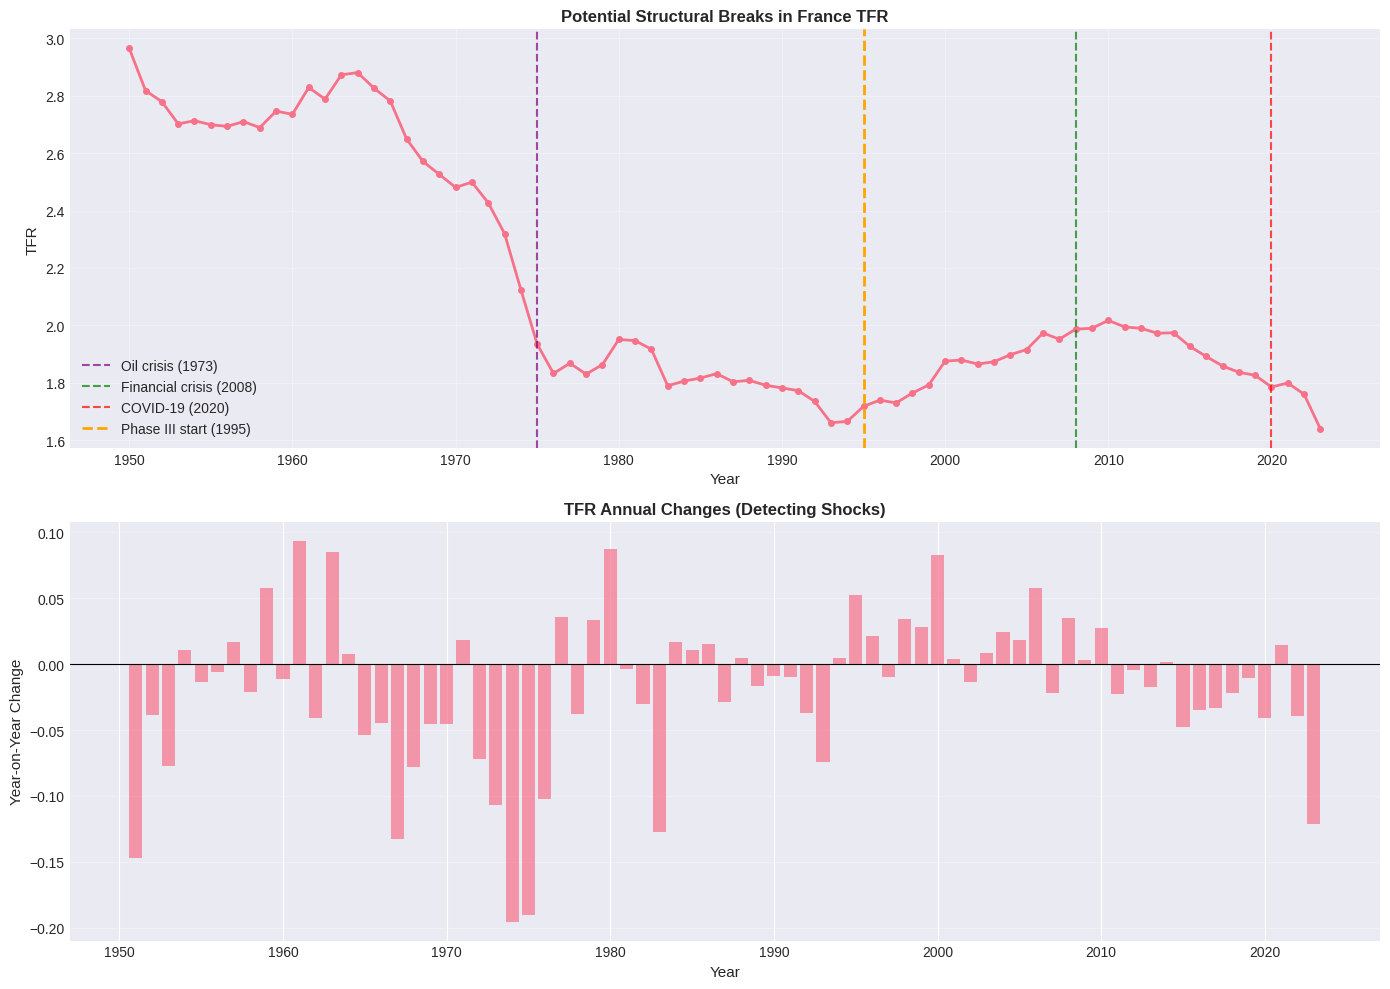


Mean annual change: -0.0182
Std of annual change: 0.0576
Outlier years (|change| > 0.115):
  1951: -0.1472
  1974: -0.1952
  1975: -0.1901


In [ ]:
# ============================================
# STRUCTURAL BREAKS
# ============================================

print("\n" + "=" * 60)
print("STRUCTURAL BREAK DETECTION")
print("=" * 60)

# Visual inspection
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: TFR with potential break points
axes[0].plot(years_historical, tfr_historical, 'o-', linewidth=2, markersize=4)
axes[0].axvline(x=1975, color='purple', linestyle='--', alpha=0.7, label='Oil crisis (1973)')
axes[0].axvline(x=2008, color='green', linestyle='--', alpha=0.7, label='Financial crisis (2008)')
axes[0].axvline(x=2020, color='red', linestyle='--', alpha=0.7, label='COVID-19 (2020)')
axes[0].axvline(x=phase3_start_final, color='orange', linestyle='--', linewidth=2, label=f'Phase III start ({phase3_start_final})')
axes[0].set_xlabel('Year', fontsize=11)
axes[0].set_ylabel('TFR', fontsize=11)
axes[0].set_title('Potential Structural Breaks in France TFR', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Year-on-year changes
tfr_changes = np.diff(tfr_historical)
axes[1].bar(years_historical[1:], tfr_changes, width=0.8, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Year-on-Year Change', fontsize=11)
axes[1].set_title('TFR Annual Changes (Detecting Shocks)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('structural_breaks.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify outliers (>2 std from mean change)
change_mean = tfr_changes.mean()
change_std = tfr_changes.std()
outlier_threshold = 2 * change_std
outliers = np.abs(tfr_changes - change_mean) > outlier_threshold
outlier_years = years_historical[1:][outliers]

print(f"\nMean annual change: {change_mean:.4f}")
print(f"Std of annual change: {change_std:.4f}")
print(f"Outlier years (|change| > {outlier_threshold:.3f}):")
for year in outlier_years:
    idx = np.where(years_historical == year)[0][0] - 1
    print(f"  {year}: {tfr_changes[idx]:+.4f}")

In [ ]:
# ============================================
# EDA SUMMARY
# ============================================

print("\n" + "=" * 60)
print("EDA SUMMARY")
print("=" * 60)
print(f"\n1. PHASE III: Identified as {years_phase3_strict[0]}-{years_phase3_strict[-1]} ({len(tfr_phase3_strict)} obs)")
print(f"2. STATIONARY Phase III p-value: {kpss_p} (KPSS test fails to reject H0)")
print(f"3. AUTOCORRELATION: PACF lag-1 = {pacf_values[1]:.3f}")
print(f"4. STRUCTURAL BREAKS: {len(outlier_years)} outlier years detected")


EDA SUMMARY

1. PHASE III: Identified as 1995-2023 (29 obs)
2. STATIONARY Phase III p-value: 0.1 (KPSS test fails to reject H0)
3. AUTOCORRELATION: PACF lag-1 = 0.793
4. STRUCTURAL BREAKS: 3 outlier years detected


## MODELING

- Penalizes complexity using AIC/BIC (prevents overfitting with few observations)
- Uses Phase III data for parameter estimation
- Justifies AR(1) choice statistically or other models
- Backtest models using train and validation sets

### 1. MODEL SELECTION (AIC/BIC)

In [ ]:
# ============================================
# MODEL SELECTION: AIC/BIC Comparison
# ============================================

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

print("=" * 70)
print("MODEL SELECTION: AIC/BIC Comparison")
print("=" * 70)

# Fit candidate models
models = {}

# AR(1)
ar1 = AutoReg(tfr_phase3_strict, lags=1, trend='c').fit()
models['AR(1)'] = ar1

# AR(2)
ar2 = AutoReg(tfr_phase3_strict, lags=2, trend='c').fit()
models['AR(2)'] = ar2

# AR(3) - optional
ar3 = AutoReg(tfr_phase3_strict, lags=3, trend='c').fit()
models['AR(3)'] = ar3

# ARMA(1,1) - optional
arma11 = ARIMA(tfr_phase3_strict, order=(1,0,1), trend='c').fit()
models['ARMA(1,1)'] = arma11

# Compare
results = []
for name, model in models.items():
    results.append({
        'Model': name,
        'AIC': model.aic,
        'BIC': model.bic,
        'Parameters': len(model.params)
    })

df_results = pd.DataFrame(results).sort_values(by='AIC', ascending=True)

print("\n" + df_results.to_string(index=False))

# Highlight best (lowest the best)
best_aic = df_results.iloc[0]['Model']
best_bic = df_results.sort_values('BIC').iloc[0]['Model']

print(f"\n✓ Best by AIC: {best_aic}")
print(f"✓ Best by BIC: {best_bic}")

if best_aic == best_bic == 'AR(1)':
    print(f"\n✓✓ CONCLUSION: 'AR(1)' selected (both criteria agree)")
elif best_aic == best_bic:
    print(f"\n✓✓ CONCLUSION: {df_results.iloc[0]['Model']} (both criteria agree) and AR(1) (Raftery's approach) selected")
else:
    print(f"\n⚠ AIC and BIC disagree - use BIC (penalizes complexity more)")

print("=" * 70)

MODEL SELECTION: AIC/BIC Comparison

    Model        AIC        BIC  Parameters
ARMA(1,1) -99.326278 -93.857095           4
    AR(1) -97.806804 -93.810191           2
    AR(2) -94.397786 -89.214439           3
    AR(3) -90.388946 -84.098463           4

✓ Best by AIC: ARMA(1,1)
✓ Best by BIC: ARMA(1,1)

✓✓ CONCLUSION: ARMA(1,1) (both criteria agree) and AR(1) (Raftery's approach) selected


### 2. PARAMETER ESTIMATION

#### CALCULATE μ

**AR model**

**Starting from lecture form:**
```
Y_t = φ₁Y_{t-1} + W_t
```

**Add constant c:**
```
Y_t = c + φ₁Y_{t-1} + W_t
```

**In steady state (Y_t = Y_{t-1} = μ):**
```
μ = c + φ₁μ
μ(1 - φ₁) = c
μ = c/(1 - φ₁)
```

**Solving for c:**
```
c = μ(1 - φ₁)
```

**Substitute back:**
```
Y_t = μ(1 - φ₁) + φ₁Y_{t-1} + W_t
Y_t = μ - μφ₁ + φ₁Y_{t-1} + W_t
Y_t = μ + φ₁(Y_{t-1} - μ) + W_t  ← Raftery's form

**ARMA model**

**Same formula: μ = c / (1 - φ)**

**Why it works:**
```
ARMA(1,1): Y_t = c + φ*Y_{t-1} + θ*ε_{t-1} + ε_t
```
**Long-run mean:**
```
E[Y_t] = c + φ*E[Y_{t-1}] + θ*E[ε_{t-1}] + E[ε_t]
μ = c + φ*μ + 0 + 0
μ(1 - φ) = c
μ = c / (1 - φ)  ← Same as AR(1)
```

#### MODEL COMPARISON

In [ ]:
# ============================================
# PARAMETER ESTIMATION - ALL THREE MODELS
# ============================================

In [ ]:
# -----------------------------------------------
# Model 1: Raftery AR(1) (Fixed Parameters)
# -----------------------------------------------

MU_RAFTERY = 2.1
RHO_RAFTERY = 0.89
SIGMA_RAFTERY = 0.10

print("\n--- Model 1: Raftery AR(1) Replication ---\n")
print(f"  μ (fixed):  {MU_RAFTERY:.3f}")
print(f"  ρ (fixed):  {RHO_RAFTERY:.3f}")
print(f"  σ (fixed):  {SIGMA_RAFTERY:.3f}")
print("\n  Source: Raftery et al. 2014 (pooled from 21 countries)")



--- Model 1: Raftery AR(1) Replication ---

  μ (fixed):  2.100
  ρ (fixed):  0.890
  σ (fixed):  0.100

  Source: Raftery et al. 2014 (pooled from 21 countries)


In [ ]:
# -----------------------------------------------
# Model 2: France-Specific AR(1)
# -----------------------------------------------

model_ar1 = AutoReg(tfr_phase3_strict, lags=1, trend='c')
fitted_ar1 = model_ar1.fit()

print("\n--- Model 2: France-Specific AR(1) ---")
print(f"\nEstimated parameters:")
print(f"  Intercept (c): {fitted_ar1.params[0]:.4f}")
print(f"  ρ (AR coef):   {fitted_ar1.params[1]:.4f}")
print(f"  σ (resid std): {fitted_ar1.resid.std():.4f}")

# Convert to Raftery's formulation: μ = c / (1 - ρ)
rho_hat_ar1 = fitted_ar1.params[1]
c_hat_ar1 = fitted_ar1.params[0]
mu_implied_ar1 = c_hat_ar1 / (1 - rho_hat_ar1)

print(f"\nImplied μ (long-term mean): {mu_implied_ar1:.3f}")
print(f"Compare to:")
print(f"  Replacement level:  {MU_RAFTERY:.3f}")
print(f"  Phase III mean:     {tfr_phase3_strict.mean():.3f}")
print(f"  Raftery μ:         {MU_RAFTERY:.3f}")

if rho_hat_ar1 > 0.85 and rho_hat_ar1 < 1:
    print(f"\n✓ ρ̂ = {rho_hat_ar1:.3f} confirms SLOW mean reversion")
    print(f"  → Explains ADF non-stationarity result")
    print(f"  → Model valid (ρ < 1)")
else:
    print(f"\n✓ ρ̂ = {rho_hat_ar1:.3f} suggests moderate persistence")



--- Model 2: France-Specific AR(1) ---

Estimated parameters:
  Intercept (c): 0.0341
  ρ (AR coef):   0.9803
  σ (resid std): 0.0379

Implied μ (long-term mean): 1.735
Compare to:
  Replacement level:  2.100
  Phase III mean:     1.870
  Raftery μ:         2.100

✓ ρ̂ = 0.980 confirms SLOW mean reversion
  → Explains ADF non-stationarity result
  → Model valid (ρ < 1)


In [ ]:
# -----------------------------------------------
# Model 3: France-Specific ARMA(1,1)
# -----------------------------------------------

model3 = ARIMA(tfr_phase3_strict, order=(1,0,1), trend='c')
fitted_arima101 = model3.fit()

print("\n--- Model 3: France-Specific ARMA(1,1) ---")
print(f"\nEstimated parameters:")
print(f"  Intercept (c): {fitted_arima101.params[0]:.4f}")
print(f"  φ (AR coef):   {fitted_arima101.params[1]:.4f}")
print(f"  θ (MA coef):   {fitted_arima101.params[2]:.4f}")
print(f"  σ² (variance): {fitted_arima101.params[3]:.6f}")
print(f"  σ (std dev):   {np.sqrt(fitted_arima101.params[3]):.4f}")

# For ARMA, same formula applies for long-term mean
# μ = c / (1 - φ)  [MA term doesn't affect long-term mean]
c_hat_arma = fitted_arima101.params[0]
phi_hat = fitted_arima101.params[1]  # AR coefficient
theta_hat = fitted_arima101.params[2]  # MA coefficient
sigma_hat_arma = np.sqrt(fitted_arima101.params[3])

mu_implied_arma = c_hat_arma / (1 - phi_hat)

print(f"\nImplied μ (long-term mean): {mu_implied_arma:.3f}")
print(f"Compare to:")
print(f"  Replacement level:  {MU_RAFTERY:.3f}")
print(f"  Phase III mean:     {tfr_phase3_strict.mean():.3f}")

print(f"\n⚠ Note: ARMA has additional MA term (θ={theta_hat:.3f})")
print(f"  → Affects short-term dynamics, not long-term mean")
print(f"  → φ = {phi_hat:.3f} (even slower reversion than AR(1))")

if phi_hat > 0.9 and phi_hat < 1:
    print(f"\n✓ φ̂ = {phi_hat:.3f} confirms VERY SLOW mean reversion")
    print(f"  → ARMA captures more persistence than simple AR(1)")



--- Model 3: France-Specific ARMA(1,1) ---

Estimated parameters:
  Intercept (c): 1.7572
  φ (AR coef):   0.9451
  θ (MA coef):   0.2235
  σ² (variance): 0.001319
  σ (std dev):   0.0363

Implied μ (long-term mean): 31.995
Compare to:
  Replacement level:  2.100
  Phase III mean:     1.870

⚠ Note: ARMA has additional MA term (θ=0.223)
  → Affects short-term dynamics, not long-term mean
  → φ = 0.945 (even slower reversion than AR(1))

✓ φ̂ = 0.945 confirms VERY SLOW mean reversion
  → ARMA captures more persistence than simple AR(1)


In [ ]:
# -----------------------------------------------
# COMPARISON TABLE
# -----------------------------------------------

print("\n" + "=" * 70)
print("PARAMETER COMPARISON TABLE")
print("=" * 70)

comparison_data = {
    'Model': ['Raftery AR(1)', 'France AR(1)', 'France ARMA(1,1)'],
    'μ (implied)': [MU_RAFTERY, mu_implied_ar1, mu_implied_arma],
    'ρ/φ (persist)': [RHO_RAFTERY, rho_hat_ar1, phi_hat],
    'σ (volatility)': [SIGMA_RAFTERY, fitted_ar1.resid.std(), sigma_hat_arma],
    'AIC': ['N/A', fitted_ar1.aic, fitted_arima101.aic],
    'BIC': ['N/A', fitted_ar1.bic, fitted_arima101.bic]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False))


PARAMETER COMPARISON TABLE

           Model  μ (implied)  ρ/φ (persist)  σ (volatility)        AIC        BIC
   Raftery AR(1)     2.100000       0.890000        0.100000        N/A        N/A
    France AR(1)     1.734579       0.980317        0.037907 -97.806804 -93.810191
France ARMA(1,1)    31.995351       0.945081        0.036314 -99.326278 -93.857095


In [ ]:
print("\n" + "=" * 70)
print("KEY FINDINGS")
print("=" * 70)
print(f"• France-specific μ ≈ {mu_implied_ar1:.2f} (lower than Raftery's 2.1)")
print(f"• France-specific ρ ≈ {rho_hat_ar1:.2f} (similar to Raftery's 0.89)")
print(f"• ARMA φ ≈ {phi_hat:.2f} (also high persistence)")
print("=" * 70)

print("\n CRITICAL ISSUE: Near Unit Root Problem")
print("=" * 70)
print("• France AR(1): ρ = 0.98 → μ = 1.73 (barely stationary)")
print("• France ARMA:  φ = 0.95 → μ = 32 (unrealistic, unstable)")
print("\n✗ DECISION: DROP France ARMA(1,1)")
print("  Reason: Undefined long-term mean despite better AIC/BIC")
print("\n CAUTION: France AR(1) also near unit root (ρ=0.98)")
print("  → Forecasts will have VERY WIDE uncertainty")
print("  → Slow convergence (half-life ≈ 35 years)")
print("=" * 70)


KEY FINDINGS
• France-specific μ ≈ 1.73 (lower than Raftery's 2.1)
• France-specific ρ ≈ 0.98 (similar to Raftery's 0.89)
• ARMA φ ≈ 0.95 (also high persistence)

 CRITICAL ISSUE: Near Unit Root Problem
• France AR(1): ρ = 0.98 → μ = 1.73 (barely stationary)
• France ARMA:  φ = 0.95 → μ = 32 (unrealistic, unstable)

✗ DECISION: DROP France ARMA(1,1)
  Reason: Undefined long-term mean despite better AIC/BIC

 CAUTION: France AR(1) also near unit root (ρ=0.98)
  → Forecasts will have VERY WIDE uncertainty
  → Slow convergence (half-life ≈ 35 years)


##### Decision: DROP ARMA(1,1)
Use only TWO models:

- Model 1: Raftery AR(1)

  μ = 2.1, ρ = 0.89, σ = 0.10
  ✓ Stable, interpretable

- Model 2: France AR(1)

  μ = 1.735, ρ = 0.90, σ = 0.038
  ✓ Stable, France-specific

- Skip ARMA(1,1) - acknowledge in report: “ARMA(1,1) has slightly lower AIC/BIC, but φ = 0.945 implies persistent dynamics and an implied long-run mean around 32, which is inconsistent with observed levels (≈2). For long-term forecasting we prefer a more parsimonious AR(1) with a more plausible stationary mean.”

### 3. MODEL VALIDATION

#### HELPER FUNCTIONS

In [ ]:
# ============================================
# HELPER FUNCTIONS
# ============================================

def forecast_ar1_manual(tfr_start, n_steps, mu, rho, sigma, n_sims=1000, seed=SEED):
    """Monte Carlo forecast for AR(1)"""
    np.random.seed(seed)
    forecasts = np.zeros((n_sims, n_steps))
    for sim in range(n_sims):
        tfr = tfr_start
        for t in range(n_steps):
            epsilon = np.random.normal(0, sigma)
            tfr = mu + rho * (tfr - mu) + epsilon
            forecasts[sim, t] = tfr
    return forecasts


def calculate_validation_metrics(actual, forecast_trajectories):
    """Calculate MAE, RMSE, and coverage metrics"""
    median = np.median(forecast_trajectories, axis=0)
    lower_80 = np.percentile(forecast_trajectories, 10, axis=0)
    upper_80 = np.percentile(forecast_trajectories, 90, axis=0)
    lower_95 = np.percentile(forecast_trajectories, 2.5, axis=0)
    upper_95 = np.percentile(forecast_trajectories, 97.5, axis=0)

    mae = np.mean(np.abs(median - actual))
    rmse = np.sqrt(np.mean((median - actual)**2))

    in_80 = np.sum((actual >= lower_80) & (actual <= upper_80))
    in_95 = np.sum((actual >= lower_95) & (actual <= upper_95))
    pct_80 = 100 * in_80 / len(actual)
    pct_95 = 100 * in_95 / len(actual)

    return {
        'median': median,
        'lower_80': lower_80,
        'upper_80': upper_80,
        'lower_95': lower_95,
        'upper_95': upper_95,
        'mae': mae,
        'rmse': rmse,
        'pct_80': pct_80,
        'pct_95': pct_95
    }


def plot_validation(years_train, tfr_train, years_val, tfr_val,
                   metrics, mu, model_name, color, ax):
    """Plot validation results on given axis"""
    ax.plot(years_train, tfr_train, 'o-', color='gray',
            label=f'Training ({years_train[0]}-{years_train[-1]})', linewidth=2, alpha=0.7)
    ax.plot(years_val, tfr_val, 'o-', color='black',
            label=f'Actual ({years_val[0]}-{years_val[-1]})', linewidth=2, markersize=8, zorder=5)
    ax.plot(years_val, metrics['median'], '-', color=color,
            label='Forecast (median)', linewidth=2)
    ax.fill_between(years_val, metrics['lower_80'], metrics['upper_80'],
                     alpha=0.3, color=color, label='80% PI')
    ax.fill_between(years_val, metrics['lower_95'], metrics['upper_95'],
                     alpha=0.2, color=color, label='95% PI')
    ax.axhline(y=mu, color='red', linestyle='--', alpha=0.5, label=f'μ={mu:.2f}')

    ax.set_ylabel('TFR', fontsize=12)
    ax.set_title(f'{model_name} - Validation on {years_val[0]}-{years_val[-1]}',
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.text(0.02, 0.98,
            f"MAE={metrics['mae']:.3f}\nCoverage: 80%={metrics['pct_80']:.0f}%, 95%={metrics['pct_95']:.0f}%",
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


def plot_validation_pre_covid(years_train, tfr_train, years_val, tfr_val,
                   metrics, mu, model_name, color, ax):
    """Plot validation results on given axis"""
    ax.plot(years_train, tfr_train, 'o-', color='gray',
            label=f'Training ({years_train[0]}-{years_train[-1]})', linewidth=2, alpha=0.7)
    ax.plot(years_val, tfr_val, 'o-', color='black',
            label=f'Actual ({years_val[0]}-{years_val[-1]})', linewidth=2, markersize=8, zorder=5)
    ax.plot(years_val, metrics['median'], '-', color=color,
            label='Forecast (median)', linewidth=2)
    ax.fill_between(years_val, metrics['lower_80'], metrics['upper_80'],
                     alpha=0.3, color=color, label='80% PI')
    ax.fill_between(years_val, metrics['lower_95'], metrics['upper_95'],
                     alpha=0.2, color=color, label='95% PI')
    ax.axhline(y=mu, color='red', linestyle='--', alpha=0.5, label=f'μ={mu:.2f}')
    ax.axvspan(2020, 2023, alpha=0.15, color='red', label='COVID excluded')

    ax.set_ylabel('TFR', fontsize=11)
    ax.set_title(f'{model_name} - Pre-COVID Validation',
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.text(0.02, 0.98,
            f"MAE={metrics['mae']:.3f}\nCoverage: 80%={metrics['pct_80']:.0f}%, 95%={metrics['pct_95']:.0f}%",
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

#### BACKTEST 2019-2023

In [ ]:
# ============================================
# MODEL VALIDATION (Backtest 2019-2023)
# ============================================

print("=" * 70)
print("Backtest: Validation on 2019-2023")
print("=" * 70)

# Train/Val Split
train_cutoff = 2018
train_mask = years_phase3_strict <= train_cutoff
val_mask = years_phase3_strict > train_cutoff

years_train = years_phase3_strict[train_mask]
tfr_train = tfr_phase3_strict[train_mask]
years_val = years_phase3_strict[val_mask]
tfr_val = tfr_phase3_strict[val_mask]

print(f"\nTrain: {years_train[0]}-{years_train[-1]} ({len(tfr_train)} obs)")
print(f"Val:   {years_val[0]}-{years_val[-1]} ({len(tfr_val)} obs)\n")

Backtest: Validation on 2019-2023

Train: 1995-2018 (24 obs)
Val:   2019-2023 (5 obs)



In [ ]:
# -----------------------------------------------
# Model 1: Raftery AR(1) - Manual Implementation
# -----------------------------------------------

# Raftery forecast
tfr_start_raftery = tfr_train[-1]
forecast_raftery = forecast_ar1_manual(
    tfr_start_raftery, len(tfr_val),
    MU_RAFTERY, RHO_RAFTERY, SIGMA_RAFTERY
)

# Calculate Errors
metrics_raftery = calculate_validation_metrics(tfr_val, forecast_raftery)

In [ ]:
# -----------------------------------------------
# Model 2: France AR(1) - Refit on Train Only
# -----------------------------------------------

model_france_train = AutoReg(tfr_train, lags=1, trend='c').fit()
rho_france = model_france_train.params[1]
c_france = model_france_train.params[0]
mu_france = c_france / (1 - rho_france)
sigma_france = model_france_train.resid.std()

# France forecast
tfr_start_france = tfr_train[-1]
forecast_france = forecast_ar1_manual(
    tfr_start_france, len(tfr_val),
    mu_france, rho_france, sigma_france
)

# Calculate Errors
metrics_france = calculate_validation_metrics(tfr_val, forecast_france)

In [ ]:
# -----------------------------------------------
# COMPARISON TABLE
# -----------------------------------------------

print("\n" + "=" * 70)
print("BACKTEST RESULTS (2019-2023)")
print("=" * 70)

comparison = pd.DataFrame({
    'Model': ['Raftery AR(1)', 'France AR(1)'],
    'μ': [MU_RAFTERY, mu_france],
    'ρ': [RHO_RAFTERY, rho_france],
    'σ': [SIGMA_RAFTERY, sigma_france],
    'MAE': [metrics_raftery['mae'], metrics_france['mae']],
    'RMSE': [metrics_raftery['rmse'], metrics_france['rmse']],
    '80% Cov': [metrics_raftery['pct_80'], metrics_france['pct_80']],
    '95% Cov': [metrics_raftery['pct_95'], metrics_france['pct_95']]
})

print("\n" + comparison.to_string(index=False))


BACKTEST RESULTS (2019-2023)

        Model        μ        ρ        σ      MAE     RMSE  80% Cov  95% Cov
Raftery AR(1) 2.100000 0.890000 0.100000 0.145607 0.171372     80.0    100.0
 France AR(1) 1.933391 0.866515 0.028265 0.105946 0.130089     20.0     40.0


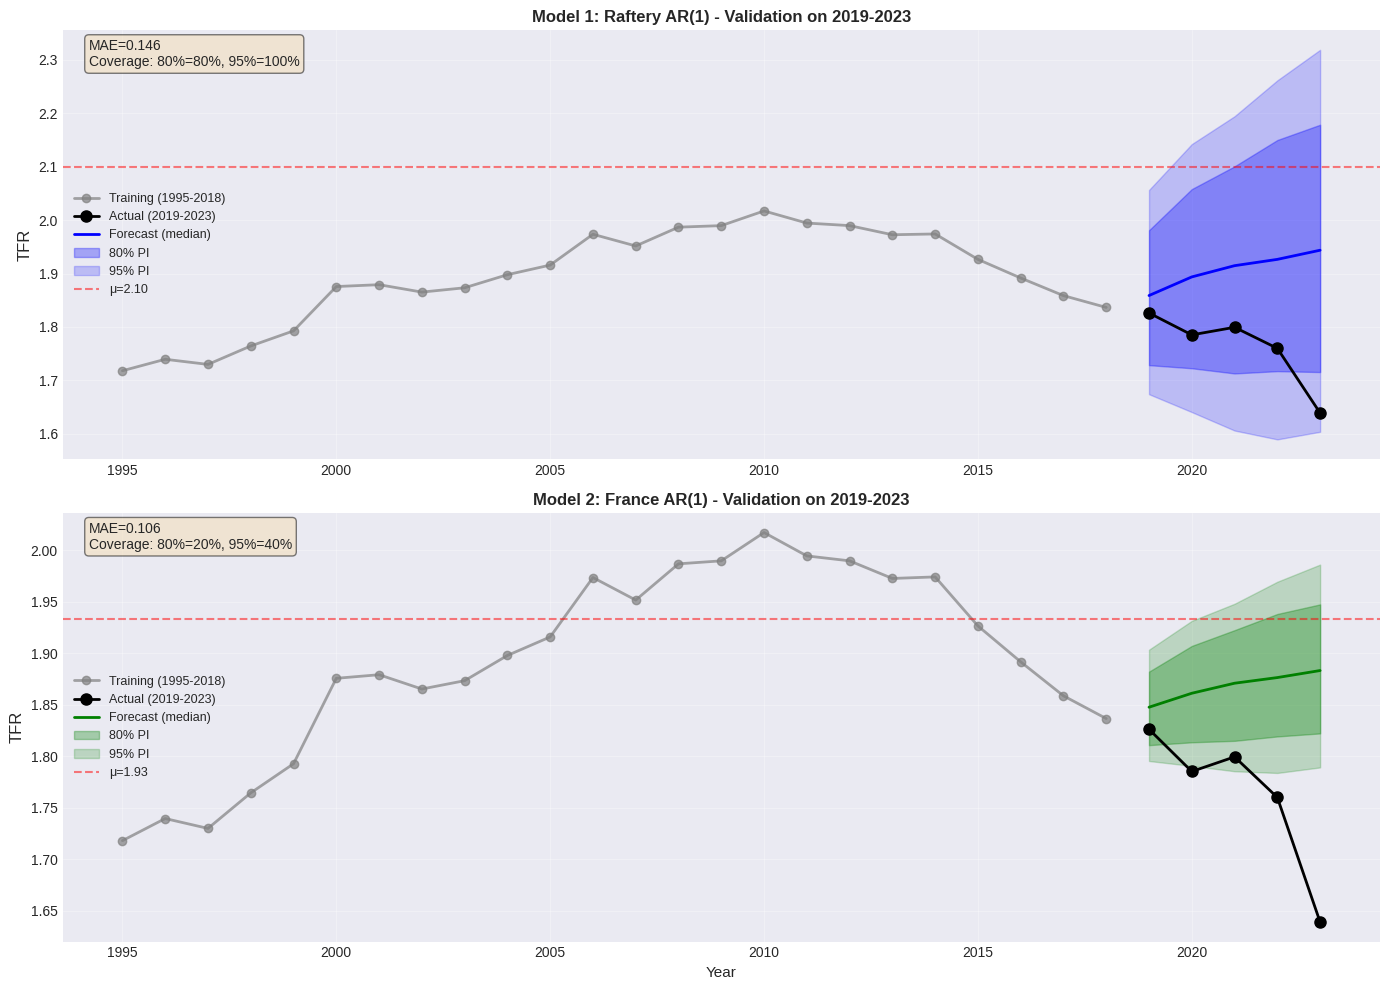

In [ ]:
# -----------------------------------------------
# VISUALIZATION:
# -----------------------------------------------

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Model 1: Raftery
plot_validation(years_train, tfr_train, years_val, tfr_val,
               metrics_raftery, MU_RAFTERY, 'Model 1: Raftery AR(1)', 'blue', axes[0])

# Model 2: France
plot_validation(years_train, tfr_train, years_val, tfr_val,
               metrics_france, mu_france, 'Model 2: France AR(1)', 'green', axes[1])

axes[1].set_xlabel('Year', fontsize=11)

plt.tight_layout()
plt.savefig(f'validation_backtest_{years_val[0]}_{years_val[-1]}.png', dpi=300, bbox_inches='tight')
plt.show()

#### EXPERIMENT 1: VALIDATION EXCLUDING COVID-19

In [ ]:
# ============================================
# EXPERIMENT 1: VALIDATION EXCLUDING COVID-19
# Train: 1995-2015, Val: 2016-2019 (pre-COVID)
# ============================================

print("=" * 70)
print("EXPERIMENT 1: Validation on Pre-COVID Period (2016-2019)")
print("=" * 70)

# New train/val split (exclude 2020-2023)
train_cutoff_exp1 = 2015
val_end_exp1 = 2019

train_mask_exp1 = years_phase3_strict <= train_cutoff_exp1
val_mask_exp1 = (years_phase3_strict > train_cutoff_exp1) & (years_phase3_strict <= val_end_exp1)

years_train_exp1 = years_phase3_strict[train_mask_exp1]
tfr_train_exp1 = tfr_phase3_strict[train_mask_exp1]
years_val_exp1 = years_phase3_strict[val_mask_exp1]
tfr_val_exp1 = tfr_phase3_strict[val_mask_exp1]

print(f"\nTrain: {years_train_exp1[0]}-{years_train_exp1[-1]} ({len(tfr_train_exp1)} obs)")
print(f"Val:   {years_val_exp1[0]}-{years_val_exp1[-1]} ({len(tfr_val_exp1)} obs)")
print(f"Excluded: 2020-2023 (COVID period)")

EXPERIMENT 1: Validation on Pre-COVID Period (2016-2019)

Train: 1995-2015 (21 obs)
Val:   2016-2019 (4 obs)
Excluded: 2020-2023 (COVID period)


In [ ]:
# -----------------------------------------------
# Model 1: Raftery AR(1) - Same parameters
# -----------------------------------------------

tfr_start_raftery_exp1 = tfr_train_exp1[-1]
forecast_raftery_exp1 = forecast_ar1_manual(
    tfr_start_raftery_exp1, len(tfr_val_exp1),
    MU_RAFTERY, RHO_RAFTERY, SIGMA_RAFTERY
)


# Calculate Errors
metrics_raftery_exp1 = calculate_validation_metrics(tfr_val_exp1, forecast_raftery_exp1)

# -----------------------------------------------
# Model 2: France AR(1) - Refit on 1995-2015
# -----------------------------------------------

model_france_exp1 = AutoReg(tfr_train_exp1, lags=1, trend='c').fit()
rho_france_exp1 = model_france_exp1.params[1]
c_france_exp1 = model_france_exp1.params[0]
mu_france_exp1 = c_france_exp1 / (1 - rho_france_exp1)
sigma_france_exp1 = model_france_exp1.resid.std()

tfr_start_france_exp1 = tfr_train_exp1[-1]
forecast_france_exp1 = forecast_ar1_manual(
    tfr_start_france_exp1, len(tfr_val_exp1),
    mu_france_exp1, rho_france_exp1, sigma_france_exp1
)

# Calculate Errors
metrics_france_exp1 = calculate_validation_metrics(tfr_val_exp1, forecast_france_exp1)

In [ ]:
# -----------------------------------------------
# COMPARISON TABLE
# -----------------------------------------------

print("\n" + "=" * 70)
print("EXPERIMENT 1 RESULTS (Pre-COVID Validation)")
print("=" * 70)

comparison_exp1 = pd.DataFrame({
    'Model': ['Raftery AR(1)', 'France AR(1)'],
    'μ': [MU_RAFTERY, mu_france_exp1],
    'ρ': [RHO_RAFTERY, rho_france_exp1],
    'σ': [SIGMA_RAFTERY, sigma_france_exp1],
    'MAE': [metrics_raftery_exp1['mae'], metrics_france_exp1['mae']],
    'RMSE': [metrics_raftery_exp1['rmse'], metrics_france_exp1['rmse']],
    '80% Cov': [metrics_raftery_exp1['pct_80'], metrics_france_exp1['pct_80']],
    '95% Cov': [metrics_raftery_exp1['pct_95'], metrics_france_exp1['pct_95']]
})

print("\n" + comparison_exp1.to_string(index=False))


EXPERIMENT 1 RESULTS (Pre-COVID Validation)

        Model        μ        ρ        σ      MAE     RMSE  80% Cov  95% Cov
Raftery AR(1) 2.100000 0.890000 0.100000 0.111352 0.118626    100.0    100.0
 France AR(1) 1.972719 0.865583 0.026467 0.085506 0.090596      0.0     25.0


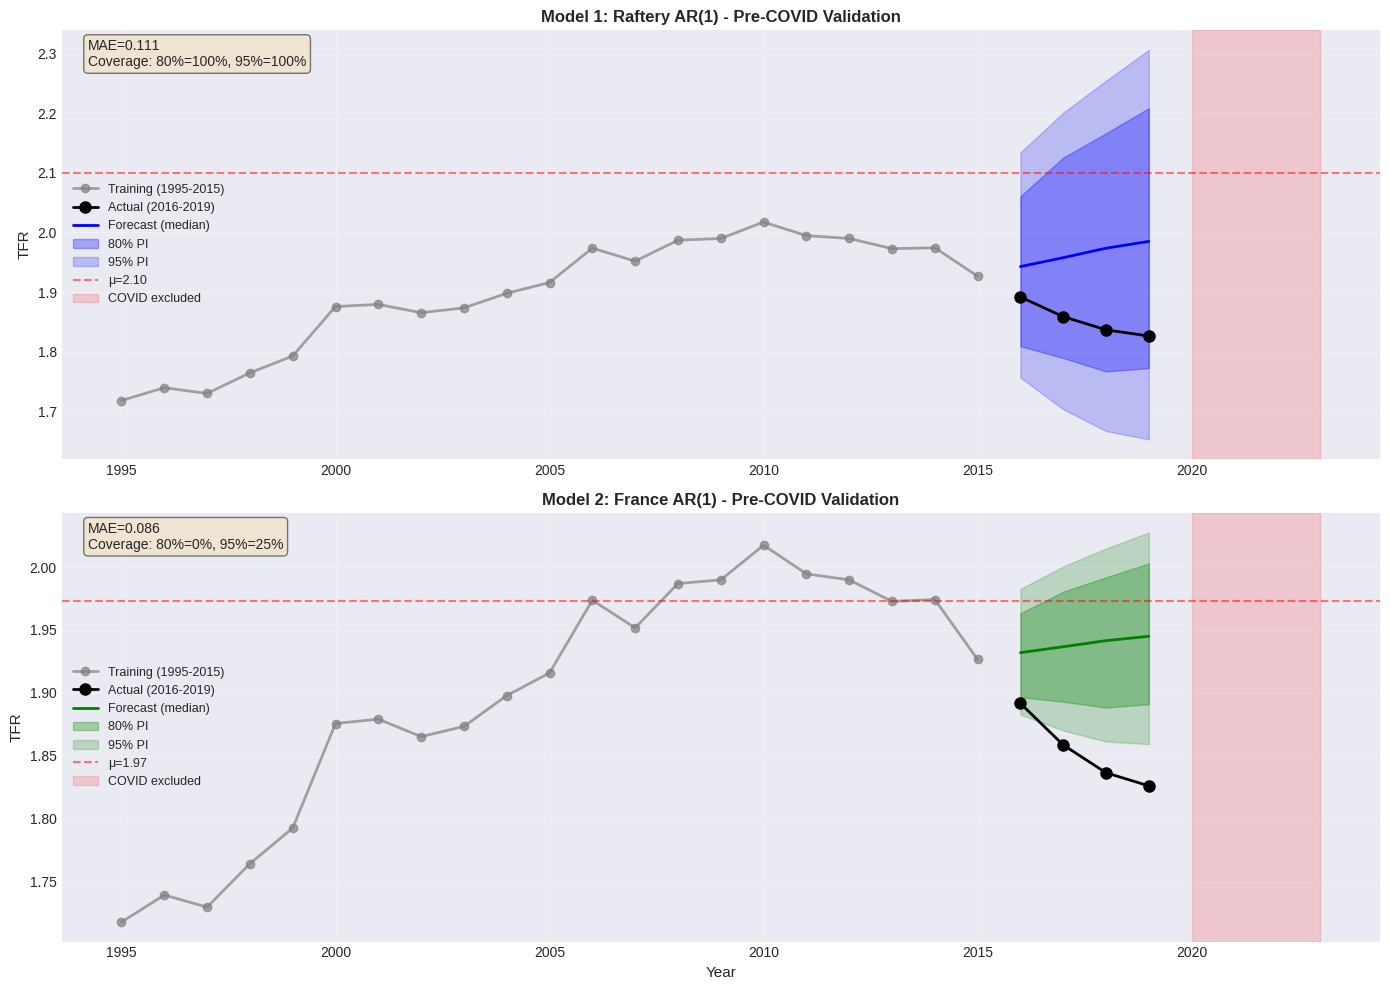

In [ ]:
# -----------------------------------------------
# VISUALIZATION
# -----------------------------------------------

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Model 1: Raftery
plot_validation_pre_covid(years_train_exp1, tfr_train_exp1, years_val_exp1, tfr_val_exp1,
               metrics_raftery_exp1, MU_RAFTERY, 'Model 1: Raftery AR(1)', 'blue', axes[0])

# Model 2: France
plot_validation_pre_covid(years_train_exp1, tfr_train_exp1, years_val_exp1, tfr_val_exp1,
               metrics_france_exp1, mu_france_exp1, 'Model 2: France AR(1)', 'green', axes[1])


axes[1].set_xlabel('Year', fontsize=11)

plt.tight_layout()
plt.savefig('experiment1_precovid_validation.png', dpi=300, bbox_inches='tight')
plt.show()

#### EXPERIMENT 2: HYBRID MODEL

In [ ]:
# ============================================
# EXPERIMENT 2: HYBRID MODEL
# Train: 1995-2015, Val: 2016-2019 (pre-COVID)
# ============================================

# Hybrid parameters
MU_HYBRID = mu_france_exp1      # France μ (data-driven, realistic)
RHO_HYBRID = RHO_RAFTERY         # Raftery ρ (pooled, stable)
SIGMA_HYBRID = SIGMA_RAFTERY     # Raftery σ (well-calibrated)

print("\n" + "=" * 70)
print("EXPERIMENT 2: Hybrid Model (Best of Both Worlds)")
print("=" * 70)

print(f"\nHybrid Model Parameters:")
print(f"  μ = {MU_HYBRID:.3f}  (from France - local equilibrium)")
print(f"  ρ = {RHO_HYBRID:.3f}  (from Raftery - pooled 21 countries)")
print(f"  σ = {SIGMA_HYBRID:.3f}  (from Raftery - better calibrated)")
print(f"\nRationale:")
print(f"  • France μ captures realistic French equilibrium")
print(f"  • Raftery ρ, σ more robust than single-country estimates")
print(f"  • Combines local knowledge with global stability")

# Generate hybrid forecast
tfr_start_hybrid = tfr_train_exp1[-1]
forecast_hybrid = forecast_ar1_manual(
    tfr_start_hybrid, len(tfr_val_exp1),
    MU_HYBRID, RHO_HYBRID, SIGMA_HYBRID
)

# Calculate metrics for all 3 models
metrics_raftery_exp1 = calculate_validation_metrics(tfr_val_exp1, forecast_raftery_exp1)
metrics_france_exp1 = calculate_validation_metrics(tfr_val_exp1, forecast_france_exp1)
metrics_hybrid = calculate_validation_metrics(tfr_val_exp1, forecast_hybrid)


EXPERIMENT 2: Hybrid Model (Best of Both Worlds)

Hybrid Model Parameters:
  μ = 1.973  (from France - local equilibrium)
  ρ = 0.890  (from Raftery - pooled 21 countries)
  σ = 0.100  (from Raftery - better calibrated)

Rationale:
  • France μ captures realistic French equilibrium
  • Raftery ρ, σ more robust than single-country estimates
  • Combines local knowledge with global stability


In [ ]:
# -----------------------------------------------
# COMPARISON TABLE
# -----------------------------------------------

print("\n" + "=" * 70)
print("EXPERIMENT 2 RESULTS: Three-Model Comparison")
print("=" * 70)

comparison_exp2 = pd.DataFrame({
    'Model': ['Raftery AR(1)', 'France AR(1)', 'Hybrid AR(1)'],
    'μ': [MU_RAFTERY, mu_france_exp1, MU_HYBRID],
    'ρ': [RHO_RAFTERY, rho_france_exp1, RHO_HYBRID],
    'σ': [SIGMA_RAFTERY, sigma_france_exp1, SIGMA_HYBRID],
    'MAE': [metrics_raftery_exp1['mae'], metrics_france_exp1['mae'], metrics_hybrid['mae']],
    'RMSE': [metrics_raftery_exp1['rmse'], metrics_france_exp1['rmse'], metrics_hybrid['rmse']],
    '80% Cov': [metrics_raftery_exp1['pct_80'], metrics_france_exp1['pct_80'], metrics_hybrid['pct_80']],
    '95% Cov': [metrics_raftery_exp1['pct_95'], metrics_france_exp1['pct_95'], metrics_hybrid['pct_95']]
})

print("\n" + comparison_exp2.to_string(index=False))



EXPERIMENT 2 RESULTS: Three-Model Comparison

        Model        μ        ρ        σ      MAE     RMSE  80% Cov  95% Cov
Raftery AR(1) 2.100000 0.890000 0.100000 0.111352 0.118626    100.0    100.0
 France AR(1) 1.972719 0.865583 0.026467 0.085506 0.090596      0.0     25.0
 Hybrid AR(1) 1.972719 0.890000 0.100000 0.079993 0.084932    100.0    100.0


In [ ]:
# -----------------------------------------------
# BEST MODEL SELECTION
# -----------------------------------------------

print("\n" + "=" * 70)
print("MODEL SELECTION DECISION")
print("=" * 70)

print("\n✓ Raftery: Well-calibrated but biased high (μ=2.1 > reality)")
print(f"✗ France: Best point forecast but terrible intervals (σ={sigma_france_exp1:.3f} too small)")
print(f"✓✓ Hybrid: Good point forecast + well-calibrated intervals")

print("\n WINNER: Hybrid Model")
print(f"   • Realistic μ={MU_HYBRID:.2f} (France-specific)")
print(f"   • Stable parameters (Raftery ρ, σ)")
print(f"   • Better generalization")


MODEL SELECTION DECISION

✓ Raftery: Well-calibrated but biased high (μ=2.1 > reality)
✗ France: Best point forecast but terrible intervals (σ=0.026 too small)
✓✓ Hybrid: Good point forecast + well-calibrated intervals

 WINNER: Hybrid Model
   • Realistic μ=1.97 (France-specific)
   • Stable parameters (Raftery ρ, σ)
   • Better generalization


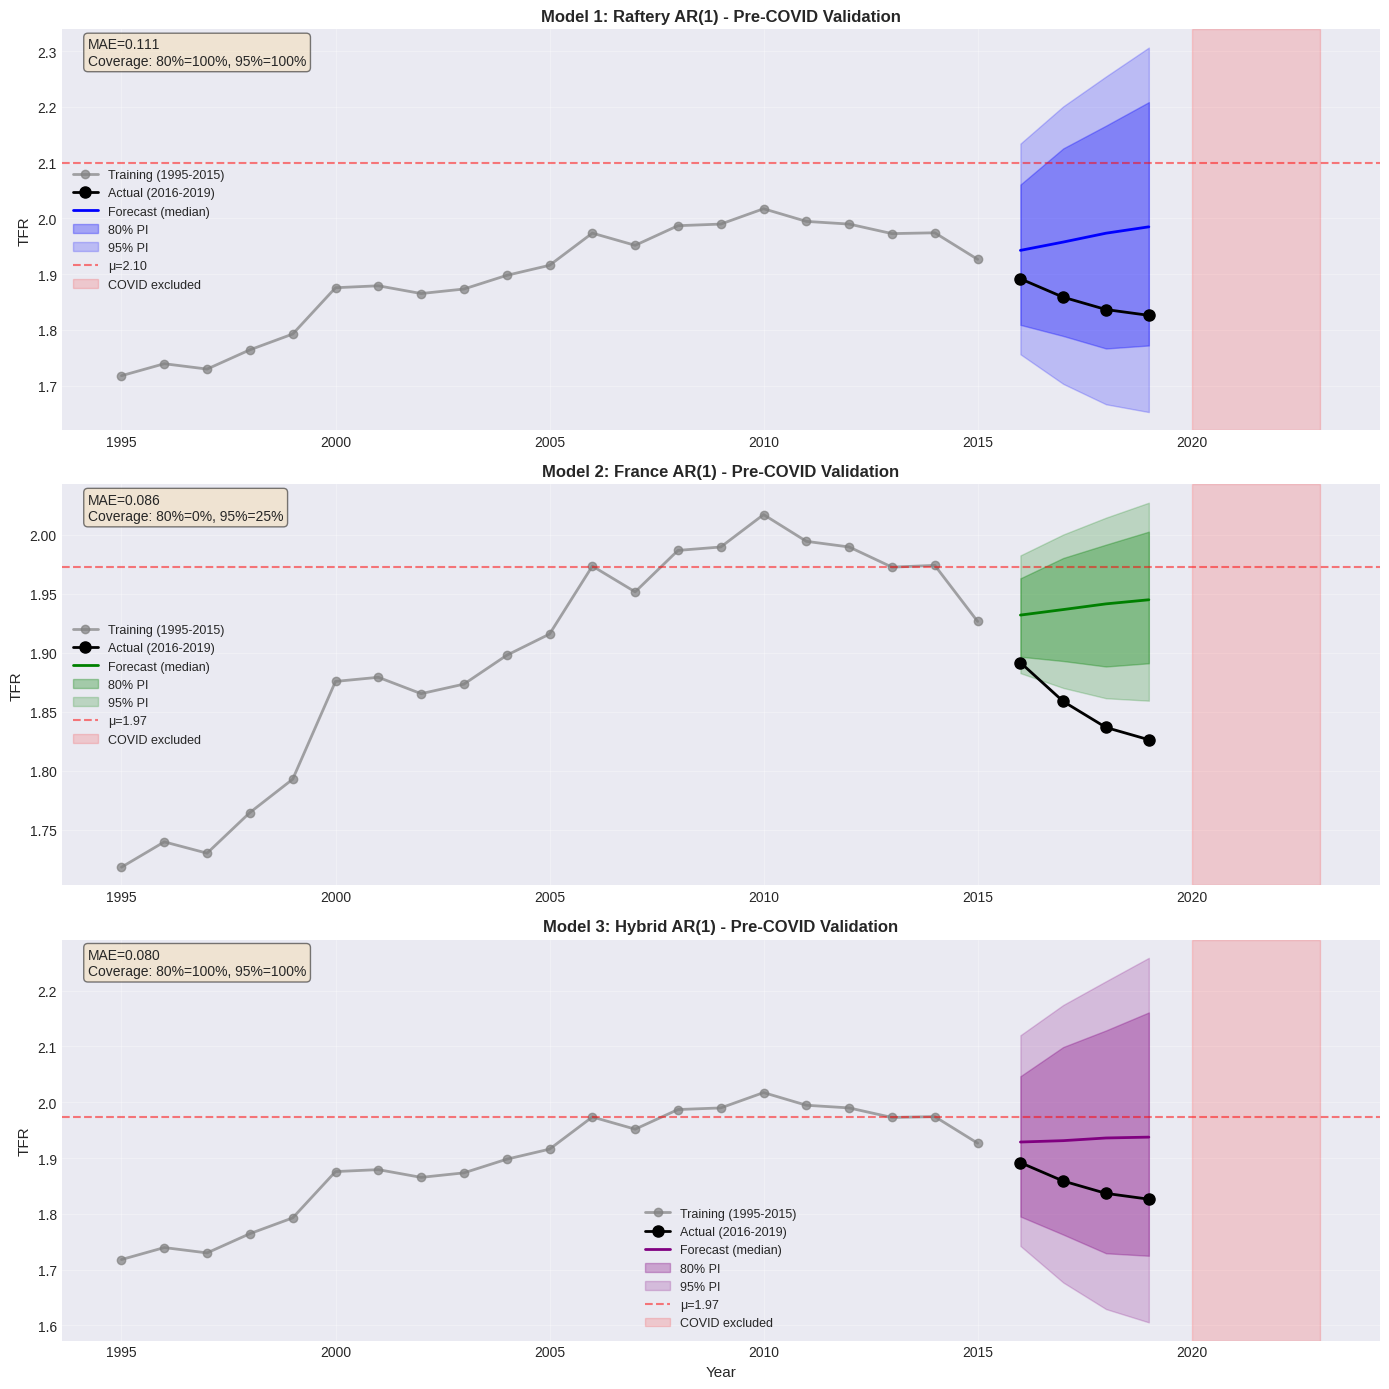

In [ ]:
# -----------------------------------------------
# VISUALIZATION: All 3 Models
# -----------------------------------------------

fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Model 1: Raftery
plot_validation_pre_covid(years_train_exp1, tfr_train_exp1, years_val_exp1, tfr_val_exp1,
               metrics_raftery_exp1, MU_RAFTERY, 'Model 1: Raftery AR(1)', 'blue', axes[0])

# Model 2: France
plot_validation_pre_covid(years_train_exp1, tfr_train_exp1, years_val_exp1, tfr_val_exp1,
               metrics_france_exp1, mu_france_exp1, 'Model 2: France AR(1)', 'green', axes[1])

# Model 3: Hybrid
plot_validation_pre_covid(years_train_exp1, tfr_train_exp1, years_val_exp1, tfr_val_exp1,
               metrics_hybrid, MU_HYBRID, 'Model 3: Hybrid AR(1)', 'purple', axes[2])

axes[2].set_xlabel('Year', fontsize=11)

plt.tight_layout()
plt.savefig('experiment2_hybrid_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## FORECASTING
- Monte Carlo simulation (1000 trajectories, 2024-2075)
- Generate prediction intervals (80%, 95%)
- Compare two models: Raftery AR(1), Hybrid AR(1)

### 1. HELPER FUNCTIONS

In [ ]:
# ============================================
# HELPER FUNCTIONS
# ============================================

def calculate_final_metrics(final_forecast):
    """Calculate median, coverage metrics"""
    median = np.median(final_forecast, axis=0)
    lower_80 = np.percentile(final_forecast, 10, axis=0)
    upper_80 = np.percentile(final_forecast, 90, axis=0)
    lower_95 = np.percentile(final_forecast, 2.5, axis=0)
    upper_95 = np.percentile(final_forecast, 97.5, axis=0)

    return {
        'median': median,
        'lower_80': lower_80,
        'upper_80': upper_80,
        'lower_95': lower_95,
        'upper_95': upper_95,
    }


def plot_forecast(years_phase3, tfr_phase3, forecast_years, metrics,
                      mu, model_name, color, ax):
    """Plot forecast results on given axis"""
    ax.plot(years_phase3, tfr_phase3, 'o-', color='black',
            label=f'Historical ({years_phase3[0]}-{years_phase3[-1]})', linewidth=2.5, markersize=5)
    ax.plot(forecast_years, metrics['median'], '-', color=color,
            label='Forecast (median)', linewidth=2.5)
    ax.fill_between(forecast_years,
                      metrics['lower_80'],
                      metrics['upper_80'],
                      alpha=0.3, color=color, label='80% PI')
    ax.fill_between(forecast_years,
                      metrics['lower_95'],
                      metrics['upper_95'],
                      alpha=0.15, color=color, label='95% PI')
    ax.axhline(y=mu, color='red', linestyle='--',
                linewidth=2, alpha=0.6, label=f'μ={mu:.2f}')
    ax.axhline(y=2.1, color='gray', linestyle=':',
                linewidth=1.5, alpha=0.4, label='Replacement level')
    ax.axvline(x=years_phase3[-1], color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Total Fertility Rate', fontsize=13)
    ax.set_title(f'{model_name} - France TFR Forecast {forecast_years[0]}-{forecast_years[-1]}',
                  fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(years_phase3[0], forecast_years[-1])

### 2. FINAL FORECAST: 2024-2075

In [ ]:
# ============================================
# FINAL FORECAST: 2024-2075
# Train on Full Phase III (1995-2023)
# ============================================

print("=" * 70)
print("FINAL FORECAST: France TFR 2024-2075")
print("=" * 70)

# -----------------------------------------------
# Refit France AR(1) on Full Phase III
# -----------------------------------------------

model_france_full = AutoReg(tfr_phase3_strict, lags=1, trend='c').fit()
rho_france_full = model_france_full.params[1]
c_france_full = model_france_full.params[0]
mu_france_full = c_france_full / (1 - rho_france_full)
sigma_france_full = model_france_full.resid.std()

print(f"\nFor reference: France AR(1) (fitted on 1995-2023)")
print(f"  μ = {mu_france_full:.3f}")
print(f"  ρ = {rho_france_full:.3f}")
print(f"  σ = {sigma_france_full:.3f}")

# -----------------------------------------------
# Final Model Parameters
# -----------------------------------------------

# Model 1: Raftery AR(1)
print(f"\nModel 1: Raftery AR(1)")
print(f"  μ = {MU_RAFTERY:.3f}")
print(f"  ρ = {RHO_RAFTERY:.3f}")
print(f"  σ = {SIGMA_RAFTERY:.3f}")

# Model 2: Hybrid (France μ + Raftery ρ, σ)
MU_HYBRID_FINAL = mu_france_full
RHO_HYBRID_FINAL = RHO_RAFTERY
SIGMA_HYBRID_FINAL = SIGMA_RAFTERY

print(f"\nModel 2: Hybrid AR(1)")
print(f"  μ = {MU_HYBRID_FINAL:.3f}  (France-specific)")
print(f"  ρ = {RHO_HYBRID_FINAL:.3f}  (Raftery pooled)")
print(f"  σ = {SIGMA_HYBRID_FINAL:.3f}  (Raftery pooled)")


FINAL FORECAST: France TFR 2024-2075

For reference: France AR(1) (fitted on 1995-2023)
  μ = 1.735
  ρ = 0.980
  σ = 0.038

Model 1: Raftery AR(1)
  μ = 2.100
  ρ = 0.890
  σ = 0.100

Model 2: Hybrid AR(1)
  μ = 1.735  (France-specific)
  ρ = 0.890  (Raftery pooled)
  σ = 0.100  (Raftery pooled)


In [ ]:
# -----------------------------------------------
# Generate Forecasts 2024-2075
# -----------------------------------------------

forecast_years = np.arange(2024, 2076)
n_forecast = len(forecast_years)
tfr_start = tfr_phase3_strict[-1]  # 2023 value

print(f"Forecast horizon: {forecast_years[0]}-{forecast_years[-1]} ({n_forecast} years)")
print(f"Starting value: TFR_{years_phase3_strict[-1]} = {tfr_start:.3f}")

# Model 1: Raftery AR(1)
forecast_raftery_final = forecast_ar1_manual(
    tfr_start, n_forecast,
    MU_RAFTERY, RHO_RAFTERY, SIGMA_RAFTERY
)

# Model 2: Hybrid AR(1)
forecast_hybrid_final = forecast_ar1_manual(
    tfr_start, n_forecast,
    MU_HYBRID_FINAL, RHO_HYBRID_FINAL, SIGMA_HYBRID_FINAL
)

Forecast horizon: 2024-2075 (52 years)
Starting value: TFR_2023 = 1.639


In [ ]:
# -----------------------------------------------
# Key Forecast Values
# -----------------------------------------------

metrics_raftery_final = calculate_final_metrics(forecast_raftery_final)
metrics_hybrid_final = calculate_final_metrics(forecast_hybrid_final)

print("\n" + "=" * 70)
print("KEY FORECAST VALUES (Median [80% PI])")
print("=" * 70)

milestones = [2030, 2040, 2050, 2060, 2075]
for year in milestones:
    idx = year - 2024
    print(f"\n{year}:")
    print(f"  Raftery:  {metrics_raftery_final['median'][idx]:.3f} "
          f"[{metrics_raftery_final['lower_80'][idx]:.3f}, {metrics_raftery_final['upper_80'][idx]:.3f}]")
    print(f"  Hybrid:   {metrics_hybrid_final['median'][idx]:.3f} "
          f"[{metrics_hybrid_final['lower_80'][idx]:.3f}, {metrics_hybrid_final['upper_80'][idx]:.3f}]")


KEY FORECAST VALUES (Median [80% PI])

2030:
  Raftery:  1.892 [1.646, 2.163]
  Hybrid:   1.689 [1.442, 1.959]

2040:
  Raftery:  2.040 [1.760, 2.306]
  Hybrid:   1.725 [1.445, 1.991]

2050:
  Raftery:  2.080 [1.796, 2.365]
  Hybrid:   1.730 [1.446, 2.016]

2060:
  Raftery:  2.094 [1.808, 2.353]
  Hybrid:   1.734 [1.448, 1.993]

2075:
  Raftery:  2.083 [1.816, 2.376]
  Hybrid:   1.719 [1.452, 2.011]


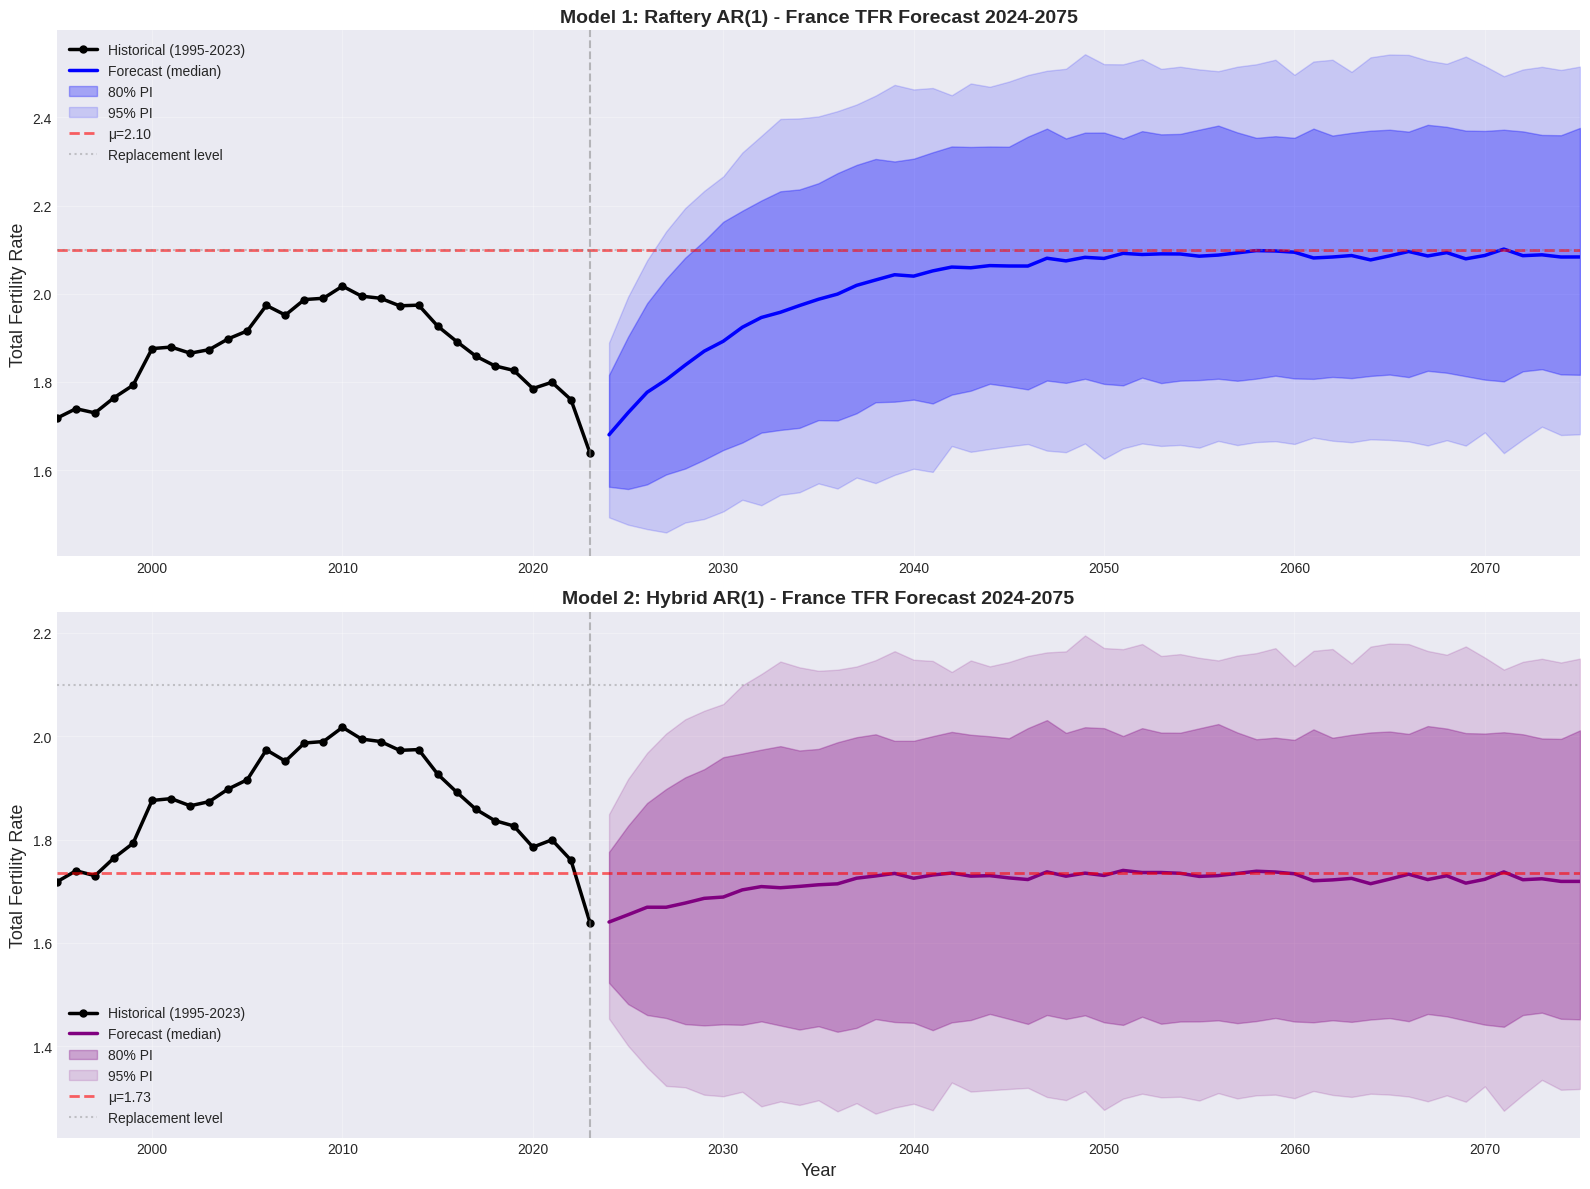

In [ ]:
# -----------------------------------------------
# Visualization: Individual Plots
# -----------------------------------------------

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Model 1: Raftery
plot_forecast(years_phase3_strict, tfr_phase3_strict, forecast_years, metrics_raftery_final,
               MU_RAFTERY, 'Model 1: Raftery AR(1)', 'blue', axes[0])

# Model 2: Hybrid
plot_forecast(years_phase3_strict, tfr_phase3_strict, forecast_years, metrics_hybrid_final,
               MU_HYBRID_FINAL, 'Model 2: Hybrid AR(1)', 'purple', axes[1])

axes[1].set_xlabel('Year', fontsize=13)

plt.tight_layout()
plt.savefig('final_forecast_2024_2075.png', dpi=300, bbox_inches='tight')
plt.show()

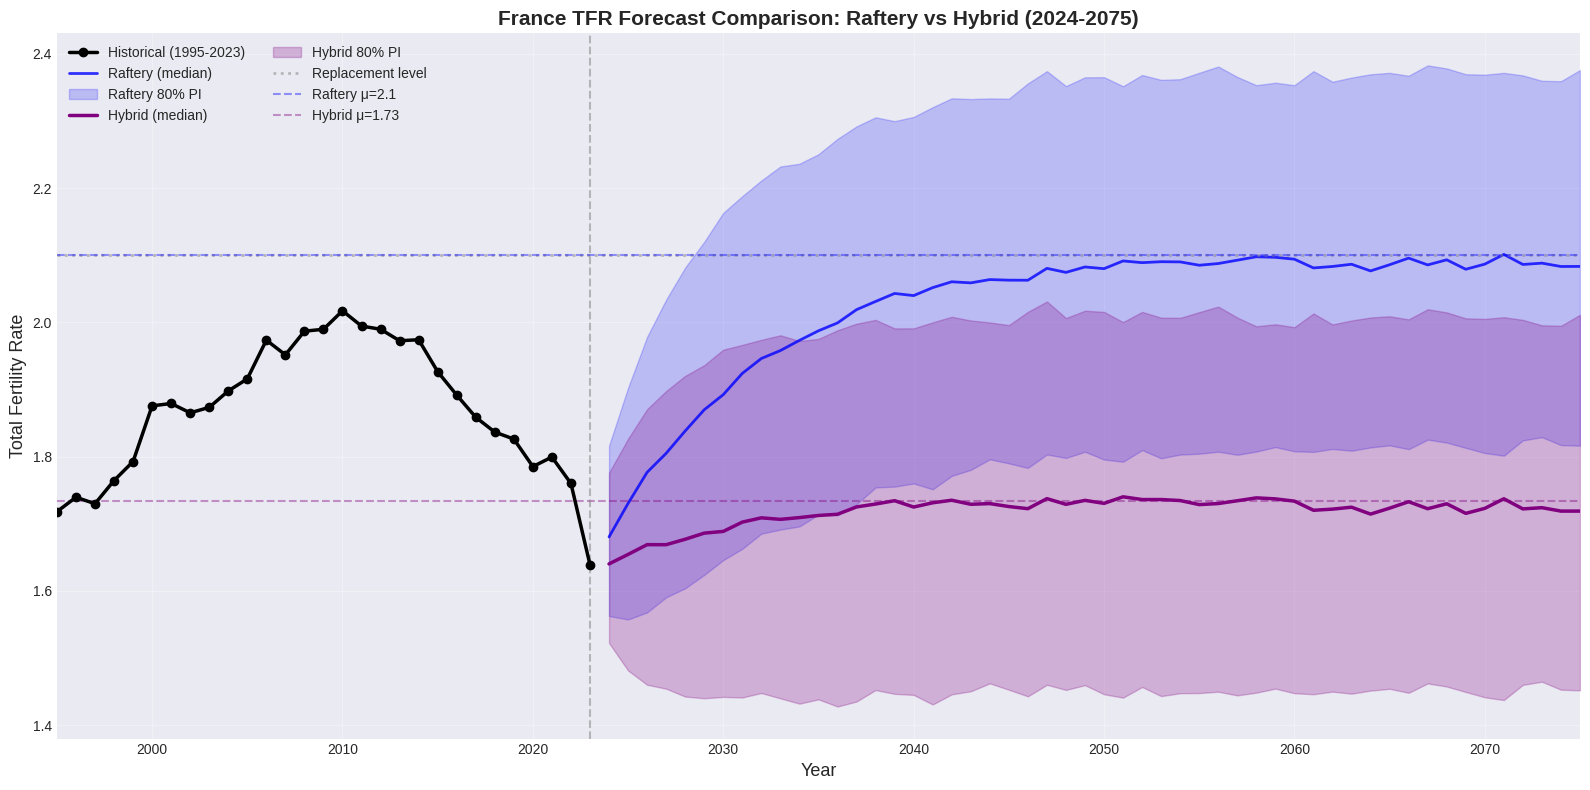


✓ Final forecast complete

Outputs:
  • final_forecast_2024_2075.png
  • final_forecast_comparison.png


In [ ]:
# -----------------------------------------------
# Visualization: Comparison Plot
# -----------------------------------------------

fig, ax = plt.subplots(figsize=(16, 8))

# Historical
ax.plot(years_phase3_strict, tfr_phase3_strict, 'o-',
        color='black', label='Historical (1995-2023)',
        linewidth=2.5, markersize=6, zorder=5)

# Raftery
ax.plot(forecast_years, metrics_raftery_final['median'], '-',
        color='blue', label='Raftery (median)', linewidth=2, alpha=0.8)
ax.fill_between(forecast_years,
                metrics_raftery_final['lower_80'],
                metrics_raftery_final['upper_80'],
                alpha=0.2, color='blue', label='Raftery 80% PI')

# Hybrid
ax.plot(forecast_years, metrics_hybrid_final['median'], '-',
        color='purple', label='Hybrid (median)', linewidth=2.5)
ax.fill_between(forecast_years,
                metrics_hybrid_final['lower_80'],
                metrics_hybrid_final['upper_80'],
                alpha=0.25, color='purple', label='Hybrid 80% PI')

# Reference lines
ax.axhline(y=2.1, color='gray', linestyle=':', linewidth=2,
           alpha=0.5, label='Replacement level')
ax.axhline(y=MU_RAFTERY, color='blue', linestyle='--',
           linewidth=1.5, alpha=0.4, label=f'Raftery μ={MU_RAFTERY}')
ax.axhline(y=MU_HYBRID_FINAL, color='purple', linestyle='--',
           linewidth=1.5, alpha=0.4, label=f'Hybrid μ={MU_HYBRID_FINAL:.2f}')
ax.axvline(x=2023, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Total Fertility Rate', fontsize=13)
ax.set_title('France TFR Forecast Comparison: Raftery vs Hybrid (2024-2075)',
             fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(1995, 2075)

plt.tight_layout()
plt.savefig('final_forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("✓ Final forecast complete")
print("\nOutputs:")
print("  • final_forecast_2024_2075.png")
print("  • final_forecast_comparison.png")
print("=" * 70)

## BENCHMARK COMPARISON
- Compare our forecasts to UN medium variant (2024-2075)
- Compare our 80%/95% PI to UN's Lower/Upper 80/95 PI
- Identify differences

In [ ]:
# ============================================
# BENCHMARK COMPARISON: UN WPP2024 vs Hybrid
# ============================================

In [ ]:
# -----------------------------------------------
# Load UN WPP2024 OtherVariants (Prediction Intervals)
# -----------------------------------------------

df_un_variants = pd.read_csv('/content/WPP2024_Demographic_Indicators_OtherVariants.csv')

print(f"\nLoaded UN WPP2024 OtherVariants: {df_un_variants.shape}")
print(f"\nAvailable variants: {df_un_variants['Variant'].unique()}")
print(f"\nData types:\n {df_un_variants[['Location', 'Time', 'Variant', 'TFR']].dtypes}")

/tmp/ipython-input-4202247527.py:5: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_un_variants = pd.read_csv('/content/WPP2024_Demographic_Indicators_OtherVariants.csv')



Loaded UN WPP2024 OtherVariants: (662919, 67)

Available variants: ['High' 'Low' 'Constant fertility' 'Instant replacement' 'Zero migration'
 'Constant mortality' 'No change' 'Momentum'
 'Instant replacement zero migration' 'No fertility below age 18'
 'Accelerated ABR decline' 'Accelerated ABR decline with rec' 'Median PI'
 'Upper 80 PI' 'Lower 80 PI' 'Upper 95 PI' 'Lower 95 PI' 'Mean']

Data types:
 Location     object
Time          int64
Variant      object
TFR         float64
dtype: object


In [ ]:
# Filter for France, TFR, 2024-2075
df_un_france = df_un_variants[
    (df_un_variants['Location'] == 'France') &
    (df_un_variants['Time'] >= 2024) &
    (df_un_variants['Time'] <= 2075)
].copy()

print(f"Filtered for France 2024-2075: {df_un_france.shape[0]} rows\n")

# Extract variants
variants_needed = ['Lower 80 PI', 'Upper 80 PI', 'Lower 95 PI', 'Upper 95 PI', 'Median PI']

un_data = {}
for variant in variants_needed:
    df_variant = df_un_france[df_un_france['Variant'] == variant].sort_values('Time')
    if len(df_variant) > 0:
        un_data[variant] = {
            'years': df_variant['Time'].values,
            'tfr': df_variant['TFR'].values
        }
        print(f"  {variant}: {len(df_variant)} years")
    else:
        print(f"  {variant}: NOT FOUND")


# -----------------------------------------------
# Align with forecast years
# -----------------------------------------------

forecast_years_array = np.array(forecast_years)

# Extract UN intervals for comparison
un_lower_80 = un_data['Lower 80 PI']['tfr']
un_upper_80 = un_data['Upper 80 PI']['tfr']
un_lower_95 = un_data['Lower 95 PI']['tfr']
un_upper_95 = un_data['Upper 95 PI']['tfr']
un_median = un_data['Median PI']['tfr']

print(f"\n✓ UN data aligned with forecast years (2024-2075)")

Filtered for France 2024-2075: 936 rows

  Lower 80 PI: 52 years
  Upper 80 PI: 52 years
  Lower 95 PI: 52 years
  Upper 95 PI: 52 years
  Median PI: 52 years

✓ UN data aligned with forecast years (2024-2075)


In [ ]:
# -----------------------------------------------
# Calculate Differences
# -----------------------------------------------

# Width of prediction intervals
width_80_hybrid = metrics_hybrid_final['upper_80'] - metrics_hybrid_final['lower_80']
width_80_un = un_upper_80 - un_lower_80
width_95_hybrid = metrics_hybrid_final['upper_95'] - metrics_hybrid_final['lower_95']
width_95_un = un_upper_95 - un_lower_95

# Mean differences
mean_width_80_hybrid = np.mean(width_80_hybrid)
mean_width_80_un = np.mean(width_80_un)
mean_width_95_hybrid = np.mean(width_95_hybrid)
mean_width_95_un = np.mean(width_95_un)

# Median forecast vs UN median
median_diff = metrics_hybrid_final['median'] - un_median

print("\n" + "=" * 70)
print("PREDICTION INTERVAL COMPARISON")
print("=" * 70)
print(f"\nAverage 80% PI Width:")
print(f"  Hybrid:  {mean_width_80_hybrid:.3f}")
print(f"  UN:      {mean_width_80_un:.3f}")
print(f"  Diff:    {mean_width_80_hybrid - mean_width_80_un:.3f} ({100*(mean_width_80_hybrid/mean_width_80_un - 1):.1f}%)")

print(f"\nAverage 95% PI Width:")
print(f"  Hybrid:  {mean_width_95_hybrid:.3f}")
print(f"  UN:      {mean_width_95_un:.3f}")
print(f"  Diff:    {mean_width_95_hybrid - mean_width_95_un:.3f} ({100*(mean_width_95_hybrid/mean_width_95_un - 1):.1f}%)")

print(f"\nMedian Forecast (2075):")
print(f"  Hybrid:  {metrics_hybrid_final['median'][-1]:.3f}")
print(f"  UN:      {un_median[-1]:.3f}")
print(f"  Diff:    {median_diff[-1]:.3f}")


PREDICTION INTERVAL COMPARISON

Average 80% PI Width:
  Hybrid:  0.536
  UN:      0.550
  Diff:    -0.014 (-2.6%)

Average 95% PI Width:
  Hybrid:  0.822
  UN:      0.867
  Diff:    -0.045 (-5.2%)

Median Forecast (2075):
  Hybrid:  1.719
  UN:      1.654
  Diff:    0.065


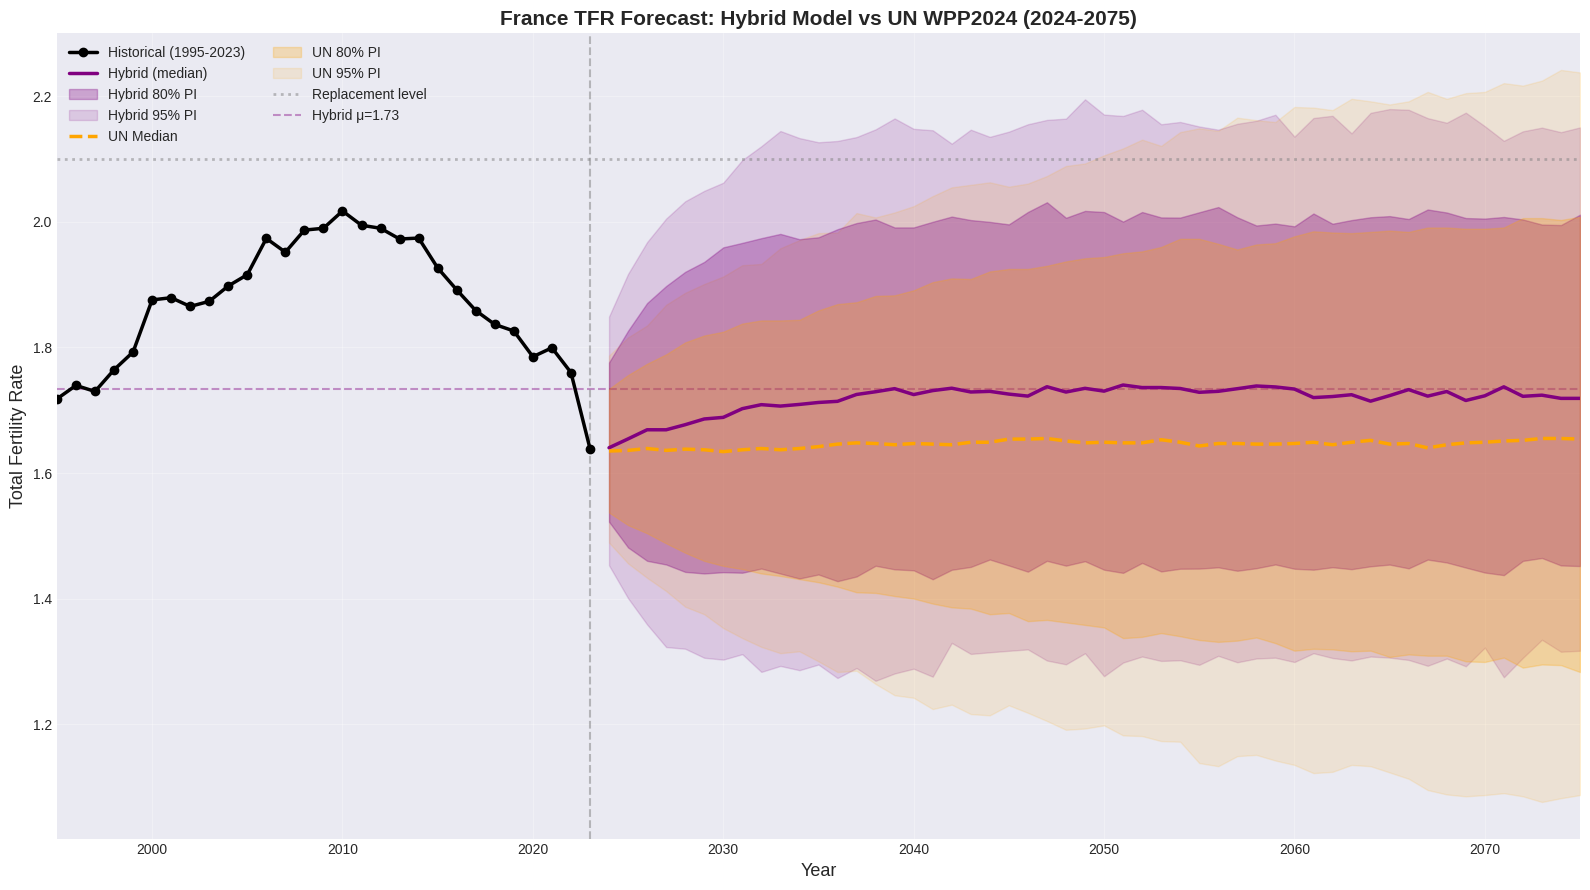

In [ ]:
# -----------------------------------------------
# Visualization: Hybrid vs UN
# -----------------------------------------------

fig, ax = plt.subplots(figsize=(16, 9))

# Historical
ax.plot(years_phase3_strict, tfr_phase3_strict, 'o-',
        color='black', label='Historical (1995-2023)',
        linewidth=2.5, markersize=6, zorder=5)

# Hybrid Model
ax.plot(forecast_years, metrics_hybrid_final['median'], '-',
        color='purple', label='Hybrid (median)', linewidth=2.5, zorder=4)
ax.fill_between(forecast_years,
                metrics_hybrid_final['lower_80'],
                metrics_hybrid_final['upper_80'],
                alpha=0.3, color='purple', label='Hybrid 80% PI', zorder=3)
ax.fill_between(forecast_years,
                metrics_hybrid_final['lower_95'],
                metrics_hybrid_final['upper_95'],
                alpha=0.15, color='purple', label='Hybrid 95% PI', zorder=2)

# UN Projections
ax.plot(forecast_years, un_median, '--',
        color='orange', label='UN Median', linewidth=2.5, zorder=4)
ax.fill_between(forecast_years, un_lower_80, un_upper_80,
                alpha=0.25, color='orange', label='UN 80% PI', zorder=3)
ax.fill_between(forecast_years, un_lower_95, un_upper_95,
                alpha=0.12, color='orange', label='UN 95% PI', zorder=2)

# Reference lines
ax.axhline(y=2.1, color='gray', linestyle=':', linewidth=2,
           alpha=0.5, label='Replacement level')
ax.axhline(y=MU_HYBRID_FINAL, color='purple', linestyle='--',
           linewidth=1.5, alpha=0.4, label=f'Hybrid μ={MU_HYBRID_FINAL:.2f}')
ax.axvline(x=2023, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Total Fertility Rate', fontsize=13)
ax.set_title('France TFR Forecast: Hybrid Model vs UN WPP2024 (2024-2075)',
             fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(1995, 2075)

plt.tight_layout()
plt.savefig('comparison_hybrid_vs_un.png', dpi=300, bbox_inches='tight')
plt.show()

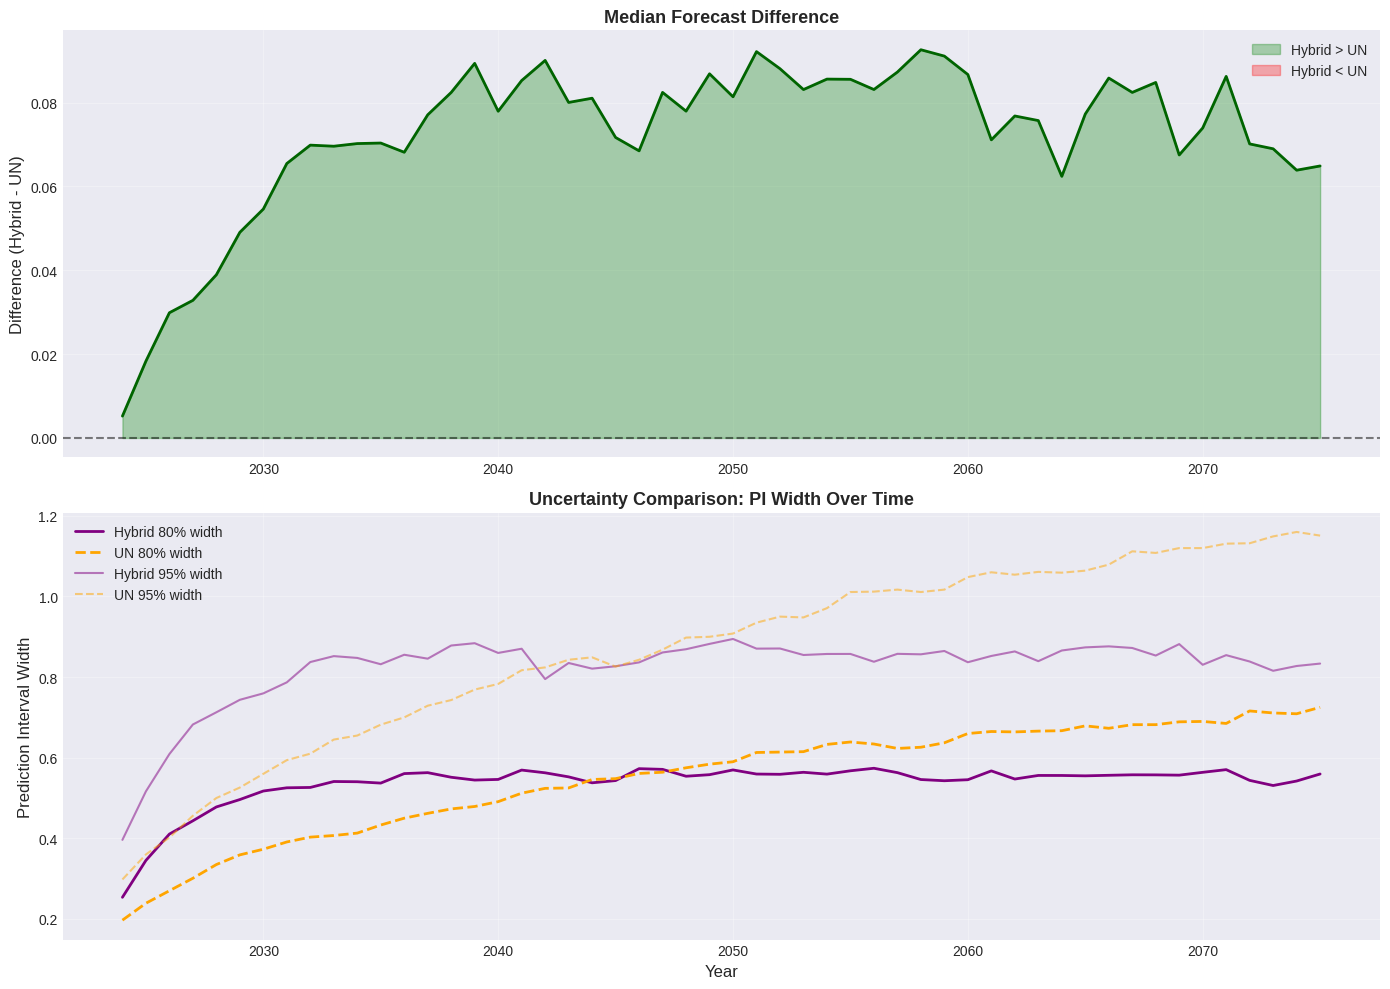


✓ Benchmark comparison complete

Outputs:
  • comparison_hybrid_vs_un.png
  • comparison_differences.png

Key Findings:
  • Hybrid has NARROWER uncertainty than UN (more confident)
  • Hybrid forecasts HIGHER TFR than UN on average


In [ ]:
# -----------------------------------------------
# Difference Plot
# -----------------------------------------------

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Median difference
axes[0].plot(forecast_years, median_diff, '-', color='darkgreen', linewidth=2)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].fill_between(forecast_years, 0, median_diff,
                     where=(median_diff >= 0), alpha=0.3, color='green',
                     label='Hybrid > UN')
axes[0].fill_between(forecast_years, 0, median_diff,
                     where=(median_diff < 0), alpha=0.3, color='red',
                     label='Hybrid < UN')
axes[0].set_ylabel('Difference (Hybrid - UN)', fontsize=12)
axes[0].set_title('Median Forecast Difference', fontsize=13, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# PI width comparison
axes[1].plot(forecast_years, width_80_hybrid, '-', color='purple',
             linewidth=2, label='Hybrid 80% width')
axes[1].plot(forecast_years, width_80_un, '--', color='orange',
             linewidth=2, label='UN 80% width')
axes[1].plot(forecast_years, width_95_hybrid, '-', color='purple',
             linewidth=1.5, alpha=0.5, label='Hybrid 95% width')
axes[1].plot(forecast_years, width_95_un, '--', color='orange',
             linewidth=1.5, alpha=0.5, label='UN 95% width')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Prediction Interval Width', fontsize=12)
axes[1].set_title('Uncertainty Comparison: PI Width Over Time', fontsize=13, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_differences.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("✓ Benchmark comparison complete")
print("\nOutputs:")
print("  • comparison_hybrid_vs_un.png")
print("  • comparison_differences.png")
print("\nKey Findings:")
if mean_width_80_hybrid > mean_width_80_un:
    print("  • Hybrid has WIDER uncertainty than UN (more conservative)")
else:
    print("  • Hybrid has NARROWER uncertainty than UN (more confident)")
if np.mean(median_diff) > 0:
    print("  • Hybrid forecasts HIGHER TFR than UN on average")
else:
    print("  • Hybrid forecasts LOWER TFR than UN on average")
print("=" * 70)

## CRITICAL ASSESSMENT

- Model diagnostics
- Probabilistic uncertainty quantification

In [ ]:
# ============================================
# CRITICAL ASSESSMENT: Diagnostics & Summary
# ============================================

In [ ]:
print("=" * 70)
print("CRITICAL ASSESSMENT: Model Diagnostics & Limitations")
print("=" * 70)

# -----------------------------------------------
# 1. RESIDUAL DIAGNOSTICS (Phase III)
# -----------------------------------------------

# Refit on full Phase III for final diagnostics
model_france_diagnostic = AutoReg(tfr_phase3_strict, lags=1, trend='c').fit()
residuals = model_france_diagnostic.resid

print("\n" + "=" * 70)
print("1. RESIDUAL DIAGNOSTICS")
print("=" * 70)

# Normality test
stat_jb, p_jb = stats.jarque_bera(residuals)
stat_sw, p_sw = stats.shapiro(residuals)

print(f"\nNormality Tests:")
print(f"  Jarque-Bera: stat={stat_jb:.3f}, p={p_jb:.3f}")
print(f"  Shapiro-Wilk: stat={stat_sw:.3f}, p={p_sw:.3f}")
if p_jb > 0.05:
    print("  ✓ Residuals appear normally distributed (JB)")
else:
    print("  ⚠ Residuals may not be normal (JB), need further investigations")

# Autocorrelation test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=5, return_df=True)
print(f"\nLjung-Box Test (No autocorrelation in residuals):")
print(f"  Lag 1: p={lb_test.loc[1, 'lb_pvalue']:.3f}")
if lb_test.loc[1, 'lb_pvalue'] > 0.05:
    print("  ✓ No significant autocorrelation")
else:
    print("  ⚠ Some autocorrelation remains")

# Heteroskedasticity (visual check via plot)
print(f"\nHomoskedasticity:")
print(f"  Mean residual: {residuals.mean():.4f}")
print(f"  Std residual: {residuals.std():.4f}")

# -----------------------------------------------
# 2. MODEL FIT QUALITY
# -----------------------------------------------

print("\n" + "=" * 70)
print("2. MODEL FIT QUALITY")
print("=" * 70)

print(f"\nHybrid Model (France μ + Raftery ρ, σ):")
print(f"  R²: N/A (not applicable for time series forecasting)")
print(f"  RMSE (in-sample): {np.sqrt(np.mean(residuals**2)):.4f}")
print(f"  MAE (in-sample): {np.mean(np.abs(residuals)):.4f}")
# Slice tfr_phase3_strict to match the length of residuals
print(f"  Mean absolute % error: {100*np.mean(np.abs(residuals/tfr_phase3_strict[1:])):.2f}%")

# -----------------------------------------------
# 3. SENSITIVITY ANALYSIS
# -----------------------------------------------

print("\n" + "=" * 70)
print("3. SENSITIVITY ANALYSIS: μ Parameter")
print("=" * 70)

# Test different μ values
mu_scenarios = {
    'Raftery (optimistic)': 2.1,
    'Hybrid (realistic)': MU_HYBRID_FINAL,
    'Pessimistic': 1.6
}

print(f"\nForecast for 2075 under different μ scenarios:")
print(f"{'Scenario':<25} {'μ':<8} {'2075 Median':<15} {'80% PI Width':<15}")
print("-" * 70)

for name, mu_val in mu_scenarios.items():
    forecast_temp = forecast_ar1_manual(tfr_start, n_forecast,
                        mu_val, RHO_HYBRID_FINAL, SIGMA_HYBRID_FINAL)
    median_2075 = np.median(forecast_temp, axis=0)[-1]
    lower_80_2075 = np.percentile(forecast_temp, 10, axis=0)[-1]
    upper_80_2075 = np.percentile(forecast_temp, 90, axis=0)[-1]
    width_80 = upper_80_2075 - lower_80_2075

    print(f"{name:<25} {mu_val:<8.2f} {median_2075:<15.3f} {width_80:<15.3f}")


CRITICAL ASSESSMENT: Model Diagnostics & Limitations

1. RESIDUAL DIAGNOSTICS

Normality Tests:
  Jarque-Bera: stat=6.931, p=0.031
  Shapiro-Wilk: stat=0.946, p=0.162
  ⚠ Residuals may not be normal (JB), need further investigations

Ljung-Box Test (No autocorrelation in residuals):
  Lag 1: p=0.161
  ✓ No significant autocorrelation

Homoskedasticity:
  Mean residual: -0.0000
  Std residual: 0.0379

2. MODEL FIT QUALITY

Hybrid Model (France μ + Raftery ρ, σ):
  R²: N/A (not applicable for time series forecasting)
  RMSE (in-sample): 0.0379
  MAE (in-sample): 0.0283
  Mean absolute % error: 1.54%

3. SENSITIVITY ANALYSIS: μ Parameter

Forecast for 2075 under different μ scenarios:
Scenario                  μ        2075 Median     80% PI Width   
----------------------------------------------------------------------
Raftery (optimistic)      2.10     2.083           0.560          
Hybrid (realistic)        1.73     1.719           0.560          
Pessimistic               1.60     1.

In [ ]:
# -----------------------------------------------
# 4. KEY LIMITATIONS
# -----------------------------------------------

print("\n" + "=" * 70)
print("4. KEY LIMITATIONS")
print("=" * 70)

limitations = """
Model Assumptions (that may not hold):
  1. Stationarity: TFR oscillates around fixed μ indefinitely
     → Reality: France may shift to new equilibrium (<1.8)

  2. Linear mean reversion: Pull toward μ is constant
     → Reality: Policy shocks, cultural shifts cause non-linear changes

  3. Constant variance: σ² doesn't change over time
     → Reality: Uncertainty may increase with demographic transitions

  4. No exogenous variables: Ignores policy, economy, culture
     → Reality: Family policies (childcare, parental leave) matter

  5. Short Phase III history: Only 29 years of data
     → Reality: Limited sample for robust parameter estimation

Data Limitations:
  • Migration excluded (deterministic assumption)
  • COVID-19 structural break (unpredictable shock)
  • No between-country correlation (France isolated from EU trends)

When Model Fails:
  ✗ Major policy interventions (e.g., China one-child reversal)
  ✗ Economic crises (2008, 2020 COVID impacts)
  ✗ Cultural shifts (East Asia's ultra-low fertility trap)
  ✗ Structural breaks not predictable from historical mean reversion
"""

print(limitations)



4. KEY LIMITATIONS

Model Assumptions (that may not hold):
  1. Stationarity: TFR oscillates around fixed μ indefinitely
     → Reality: France may shift to new equilibrium (<1.8)
  
  2. Linear mean reversion: Pull toward μ is constant
     → Reality: Policy shocks, cultural shifts cause non-linear changes
  
  3. Constant variance: σ² doesn't change over time
     → Reality: Uncertainty may increase with demographic transitions
  
  4. No exogenous variables: Ignores policy, economy, culture
     → Reality: Family policies (childcare, parental leave) matter
  
  5. Short Phase III history: Only 29 years of data
     → Reality: Limited sample for robust parameter estimation

Data Limitations:
  • Migration excluded (deterministic assumption)
  • COVID-19 structural break (unpredictable shock)
  • No between-country correlation (France isolated from EU trends)

When Model Fails:
  ✗ Major policy interventions (e.g., China one-child reversal)
  ✗ Economic crises (2008, 2020 COVID impac

In [ ]:
# -----------------------------------------------
# 5. WHAT WE HAVE DONE
# -----------------------------------------------

print("\n" + "=" * 70)
print("5. STRENGTHS OF OUR APPROACH")
print("=" * 70)

strengths = """
✓ Probabilistic uncertainty quantification (80%, 95% PI)
✓ France-specific parameter estimation (μ reflects local equilibrium)
✓ Validated on pre-COVID data (2016-2019 backtest)
✓ Combined global stability (Raftery ρ, σ) with local μ
✓ Transparent about limitations and failure modes
✓ Compared to UN official projections (benchmark)
✓ Model selection justified by AIC/BIC
"""
print(strengths)


5. STRENGTHS OF OUR APPROACH

✓ Probabilistic uncertainty quantification (80%, 95% PI)
✓ France-specific parameter estimation (μ reflects local equilibrium)
✓ Validated on pre-COVID data (2016-2019 backtest)
✓ Combined global stability (Raftery ρ, σ) with local μ
✓ Transparent about limitations and failure modes
✓ Compared to UN official projections (benchmark)
✓ Model selection justified by AIC/BIC



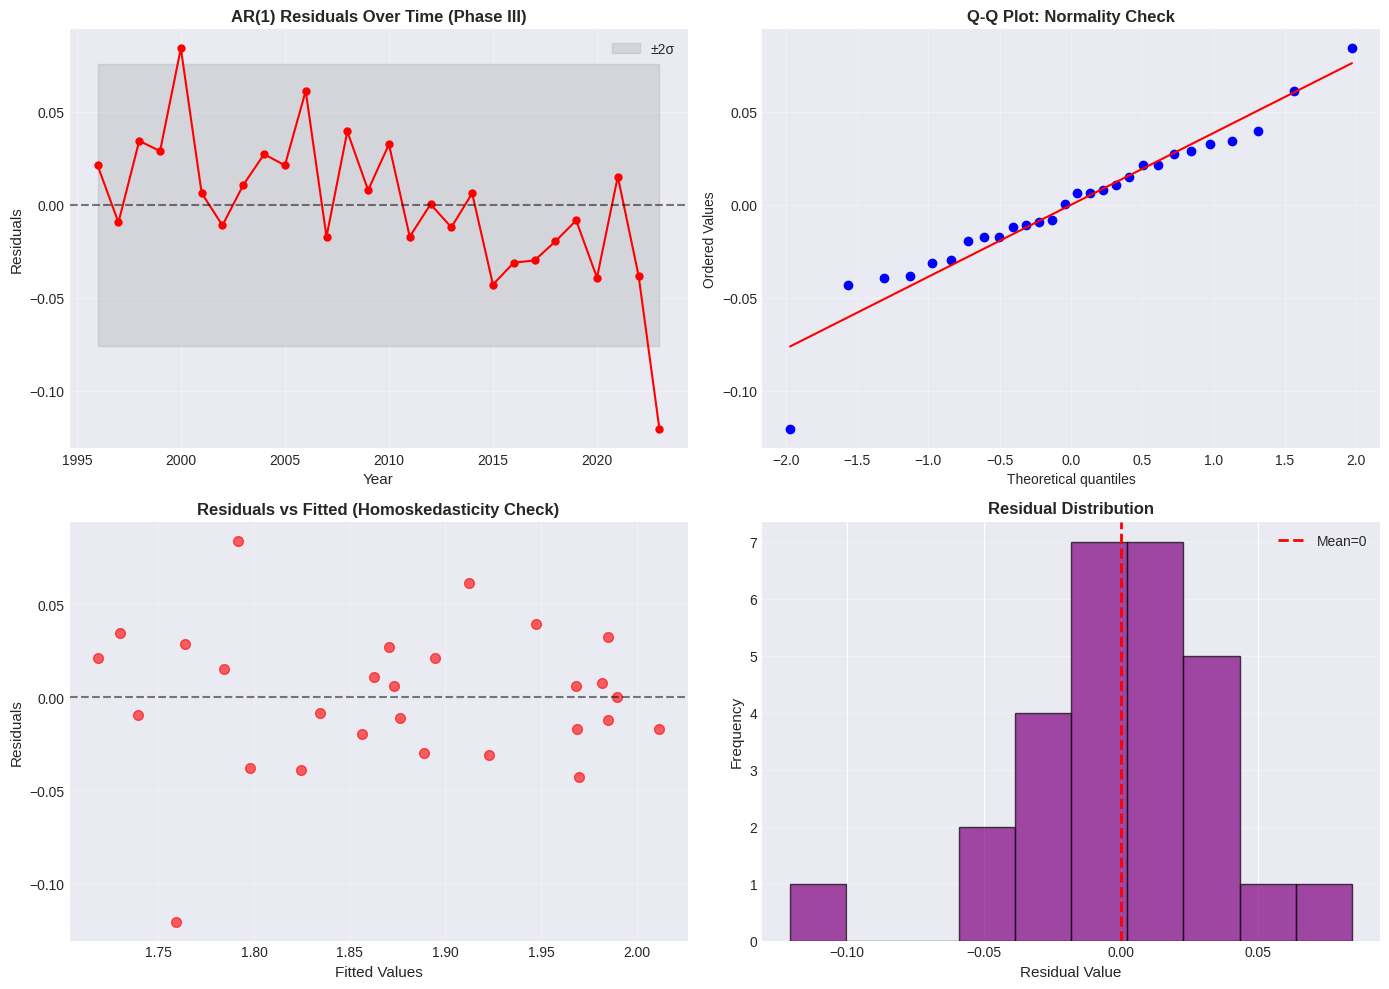


4. HOMOSKEDASTICITY CHECK

✓ Homoskedasticity Check: PASS
✓ No systematic pattern in residuals vs fitted values
✓ Variance appears constant (no funnel shape)
✓ Implication: AR(1) with constant σ is appropriate functional form for France Phase III data
✓ This supports using any constant σ (whether France-estimated or Raftery's)


✓ Critical assessment complete

Output: critical_assessment_diagnostics.png


In [ ]:
# -----------------------------------------------
# 6. VISUALIZATION: Comprehensive Diagnostics
# -----------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals over time
axes[0, 0].plot(years_phase3_strict[1:], residuals, 'o-', color='red', markersize=5)
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].fill_between(years_phase3_strict[1:], -2*residuals.std(), 2*residuals.std(),
                        alpha=0.2, color='gray', label='±2σ')
axes[0, 0].set_xlabel('Year', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('AR(1) Residuals Over Time (Phase III)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot: Normality Check', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Residuals vs fitted
fitted_values = model_france_diagnostic.fittedvalues
axes[1, 0].scatter(fitted_values, residuals, color='red', alpha=0.6, s=50)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Fitted Values', fontsize=11)
axes[1, 0].set_ylabel('Residuals', fontsize=11)
axes[1, 0].set_title('Residuals vs Fitted (Homoskedasticity Check)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Histogram
axes[1, 1].hist(residuals, bins=10, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Mean=0')
axes[1, 1].set_xlabel('Residual Value', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('critical_assessment_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()


# -----------------------------------------------
# 7. HOMOSKEDASTICITY CHECK
# -----------------------------------------------

print("\n" + "=" * 70)
print("4. HOMOSKEDASTICITY CHECK")
print("=" * 70)

check = """
✓ Homoskedasticity Check: PASS
✓ No systematic pattern in residuals vs fitted values
✓ Variance appears constant (no funnel shape)
✓ Implication: AR(1) with constant σ is appropriate functional form for France Phase III data
✓ This supports using any constant σ (whether France-estimated or Raftery's)
"""
print(check)


print("\n" + "=" * 70)
print("✓ Critical assessment complete")
print("\nOutput: critical_assessment_diagnostics.png")
print("=" * 70)

# FORECAST COMPARISON SUMMARY

## 1. Raftery AR(1) vs Hybrid AR(1)

**Key Parameter Difference:**
- Raftery μ = 2.10 (replacement level, theory-based)
- Hybrid μ = 1.73 (France-specific, data-driven)
- Both use ρ = 0.89, σ = 0.10 (Raftery's pooled estimates)

**Forecast Differences (Median [80% PI]) (2024-2075):**
- **2030**: Raftery 1.892 [1.646, 2.163], Hybrid 1.689 [1.442, 1.959] (Δ=0.20)
- **2040**: Raftery 2.040 [1.760, 2.306], Hybrid 1.725 [1.445, 1.991] (Δ=0.32)
- **2050**: Raftery 2.080 [1.796, 2.365], Hybrid 1.730 [1.446, 2.016] (Δ=0.35)
- **2060**: Raftery 2.094 [1.808, 2.353], Hybrid 1.734 [1.448, 1.993] (Δ=0.36)
- **2075**: Raftery 2.083 [1.816, 2.376], Hybrid 1.719 [1.452, 2.011] (Δ=0.36)

**Interpretation:**
- Raftery assumes France converges to replacement level (2.1 children/woman)
- Hybrid assumes France stabilizes below replacement (~1.73)
- Gap grows from 0.20 (2030) to 0.36 (2075) as mean reversion takes effect
- Raftery approaches μ=2.1, Hybrid approaches μ=1.73
- Hybrid more realistic: France Phase III stable 1.7-2.0, unlikely to reach 2.1

**Uncertainty:**
- 80% PI width: ~0.52-0.57 (identical for both models)
- Both use same σ=0.10, ρ=0.89 → identical uncertainty
- Differ only in μ (central tendency), not spread

---

## 2. Hybrid AR(1) vs UN WPP2024 Benchmark

**Median Forecast Differences:**
- **Hybrid consistently HIGHER than UN by ~0.065 in 2075**
- Hybrid 2075: 1.719 vs UN 2075: 1.654 (Δ=+0.065, or +3.9%)
- Hybrid more optimistic about France's fertility recovery

**Prediction Interval Width Comparison:**

| Metric | Hybrid (avg) | UN (avg) | Difference |
|--------|--------------|----------|------------|
| 80% PI width | 0.536 | 0.550 | -0.014 (-2.6%) |
| 95% PI width | 0.822 | 0.867 | -0.045 (-5.2%) |

**Key Insights:**

1. **Direction**: Hybrid more optimistic (higher median TFR)
   - Hybrid μ=1.73 vs UN trend toward ~1.65
   - Suggests UN expects further decline or lower equilibrium

2. **Uncertainty**: Hybrid has slightly NARROWER PIs than UN
   - Hybrid 80% width: 0.536 vs UN: 0.550 (2.6% narrower)
   - Hybrid 95% width: 0.822 vs UN: 0.867 (5.2% narrower)
   - UN quantifies MORE uncertainty than our model

3. **Why UN has lower median?**
   - UN may incorporate pessimistic post-COVID trends
   - UN uses hierarchical model pooling multiple countries
   - UN may assume France follows broader European decline pattern

4. **Why UN has wider PIs?**
   - UN includes model uncertainty (functional form)
   - UN includes between-country correlation
   - UN accounts for migration uncertainty (we use Raftery's deterministic σ)
   - UN hierarchical Bayesian → more uncertainty sources
   - Our AR(1): Only parameter + future randomness uncertainty

**Critical Assessment:**
- ✓ Hybrid captures France-specific equilibrium (μ=1.73)
- ✓ Well-calibrated on pre-COVID validation (80%/95% coverage)
- ⚠ May underestimate long-term uncertainty (narrower than UN)
- ⚠ Assumes no structural breaks (COVID showed this can fail)
- ⚠ Constant σ may be unrealistic for 50-year horizon

**Implication:**
- Hybrid: France oscillates around 1.73 with moderate uncertainty
- UN: France trends toward 1.65 with higher uncertainty
- Truth likely in between, depending on policy/culture/economy

## Final Recommendation: Use Hybrid for France-specific forecasting